# **Guide for Setup Raspi4 in home**

### **Crosstool-NG Guide**

---

#### **Table of Contents**
1. [Using the Toolchain](#using-the-toolchain)
2. [Assembling a Root Filesystem](#assembling-a-root-filesystem)
    - [Option 1: Install Directly into the Sysroot of the Toolchain](#option-1-install-directly-into-the-sysroot-of-the-toolchain)
    - [Option 2: Copy the Toolchain’s Sysroot to the Staging Area](#option-2-copy-the-toolchains-sysroot-to-the-staging-area)
    - [Option 3: Use Separate Staging and Sysroot Directories](#option-3-use-separate-staging-and-sysroot-directories)
    - [Option 4: A Mix of Options 2 and 3 Using Union Mounts](#option-4-a-mix-of-options-2-and-3-using-union-mounts)
3. [The Populate Script](#the-populate-script)
4. [The Cross-LDD Script](#the-cross-ldd-script)
5. [Copying to sd card](#Copying-to-sd-card)
---

### **Using the Toolchain**
1. Add the toolchain's `bin` directory to your `PATH`:
```bash
   export PATH="${PATH}:/your/toolchain/path/bin"
```
2. Specify the toolchain for your project:
- **Using GNU Autotools**:  
```bash
./configure --host=your-host-tuple --build=your-build-tuple
```

- **Using `make`**:  

```bash
make CC=your-host-tuple-gcc
make CROSS_COMPILE=your-host-tuple-
make CHOST=your-host-tuple
```
- Refer to the package documentation for specific instructions on cross-compiling.

**Note**:  
- **Host** refers to the program's target, not the host of the toolchain.  
- **Build** refers to the machine building the program.

> The next is our mission to assemble our rootfs

### **Assembling a Root Filesystem** 
To create a root filesystem for a target device, follow these steps:

#### **Option 1: Install Directly into the Sysroot of the Toolchain**
- Default behavior allows the compiler to find headers and libraries under the toolchain’s sysroot without extra flags.
- Example:

```bash
./configure --build=<build tuple> --host=<host tuple> --prefix=/usr --enable-foo-bar
make
make DESTDIR=/<ct-ng install path>/<host tuple>/sysroot install
```

- **Disadvantage**: Pollutes the toolchain, making it unsuitable for reuse.

#### **Option 2: Copy the Toolchain’s Sysroot to the Staging Area**
1. Copy the sysroot to a staging area:

```bash
cp -a $(<host tuple>-gcc --your-cflags-except-sysroot -print-sysroot) /path/to/staging
```
2. Build and install:

```bash
./configure --build=<build tuple> --host=<host tuple> \
            --prefix=/usr --enable-foo-bar \
            CC="<host tuple>-gcc --sysroot=/path/to/staging" \
            CXX="<host tuple>-g++ --sysroot=/path/to/staging" \
            LD="<host tuple>-ld --sysroot=/path/to/staging"
make
make DESTDIR=/path/to/staging install
```
    - **Disadvantage**: Requires `CFLAGS` or a wrapper to include `--sysroot=<staging area>`.

#### **Option 3: Use Separate Staging and Sysroot Directories**
1. Build and install with custom paths:

```bash
./configure --build=<build tuple> --host=<host tuple> \
            --prefix=/usr --enable-foo-bar \
            CPPFLAGS="-I/path/to/staging/usr/include" \
            LDFLAGS="-L/path/to/staging/lib -L/path/to/staging/usr/lib"
make
make DESTDIR=/path/to/staging install
```
#### **Option 4: A Mix of Options 2 and 3 Using Union Mounts**
- Use a union mount of:
- Sysroot (read-only)
- Staging area (read-write)
- Pass `--sysroot` to point to the union mount.
- **Note**: Requires non-mainstream Linux kernel support or FUSE-based unionfs.

### **The Populate Script**
1. **Purpose**: Populate a root directory with only the necessary libraries.
2. **Usage**:
   
```bash
your-target-tuple-populate -s /your/root -d /your/root-populated
```
- `-s src_dir`: Source directory (unpopulated root).
- `-d dst_dir`: Destination directory (populated root).
- `-l lib1 [...]: Add specified libraries.
- `-L file`: Add libraries listed in a file.
- `-f`: Force remove destination directory if it exists.
- `-v`: Verbose output.

3. **Steps**:
- Perform sanity checks.
- Copy source to destination.
- Add forced libraries.
- Add all missing libraries using `ELF` scanning.
- Create populated rootfs.


### **The Cross-LDD Script**
1. **Purpose**: Resolve dynamic library dependencies for a target.
2. **Usage**:

```bash
powerpc64-multilib-linux-gnu-ldd --root=`powerpc64-multilib-linux-gnu-gcc -print-sysroot` example
```
3. **Output**:

```plaintext
libc.so.6 => /lib64/libc.so.6 (0x00000000deadbeef)
ld64.so.1 => /lib64/ld64.so.1 (0x00000000deadbeef)
```
- **Note**: Does not load libraries but outputs required dependencies.  


### **Copying to Sd-card**

**Mount the SD card partitions:**
```bash
Boot partition (/boot/) should be mounted at /media/pi/boot.
Root filesystem partition (/) should be mounted at /media/pi/rootfs.
```

**Copy the Toolchain and Compiled Binaries:**
```bash
cp -r /path/to/your/toolchain/bin/* /media/pi/rootfs/usr/bin/
cp -r /path/to/your/toolchain/lib/* /media/pi/rootfs/usr/lib/
cp -r /path/to/your/toolchain/include/* /media/pi/rootfs/usr/include/
```

**Copy the Sysroot (if used):**
```bash
cp -r /path/to/your/sysroot/* /media/pi/rootfs/
```

**Copy Boot Files:**
```bash
cp /path/to/raspberrypi/boot/* /media/pi/boot/
```


**Copy the Populated Root Filesystem (if applicable):**
```bash
cp -r /path/to/your/rootfs/* /media/pi/rootfs/
```


```plaintext
/boot/
  config.txt
  cmdline.txt
  kernel.img (or kernel7.img for older models)
  *.dtb (device tree blobs)

/lib/
  /modules/ (kernel modules)

/usr/
  /bin/ (your compiled binaries)
  /lib/ (your compiled libraries)
  /include/ (your header files)

/rootfs/ (if using a custom root filesystem populated by the populate script)
```


By following these guidelines, you can effectively use `crosstool-NG` for building toolchains and managing cross-compilation.

**ct-ng**

[toolchain-usage](https://crosstool-ng.github.io/docs/toolchain-usage/)


> we will use **option 3**

#### **Option 3: Use Separate Staging and Sysroot Directories**

```plaintext
./configure --host=aarch64-linux-gnu \
            --build=x86_64-pc-linux-gnu \
            --prefix=${PWD}\  #"this path of installation"
            CPPFLAGS="-I/home/user/staging/usr/include" \
            LDFLAGS="-L/home/user/staging/lib -L/home/user/staging/usr/lib" \
            --sysroot=/home/user/sysroot
```

If you want more control over the installation directories:

```bash
./configure --host=<host-tuple> --prefix=/usr CPPFLAGS="-I/path/to/staging/usr/include" LDFLAGS="-L/path/to/staging/lib"
    make
    make DESTDIR=/path/to/staging install
        OR
    build =  make + make install
```

```bash


> Last Update 26/12/2024 --->  
    bcm2711_defconfig    Raspberry Pi 4, Compute Module 4	ARMv8 64-bit    aarch64-rpi4-linux-gnu


# Target Raspberry Pi 4 (rpi4 ARMv8):
# Version of linux (5.15.118)  
# little endian
# 64 bit
# C compiler GNU GCC 12.3.0 
#  Version of binutils (2.39) 

# ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ sudo apt install binutils-source

# ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ ./ct-ng clean

# ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ cd ./autoconf-2.71

# ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng/autoconf-2.71$ ./configure

# ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng/autoconf-2.71$ make

# ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng/autoconf-2.71$ sudo make install

# ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng/autoconf-2.71$ cd ../

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ ./bootstrap

# ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$  ./configure --enable-local 

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$  ./configure --prefix=${PWD}

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ make

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ make install

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ export PATH="${PWD}/bin:${PATH}"

#  Broadcom BCM2711, Quad core Cortex-A72 (ARM v8) 64-bit SoC @ 1.5GHz
ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ ./ct-ng list-samples

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ ./ct-ng aarch64-rpi4-linux-gnu


ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ ./ct-ng menuconfig

```

```plaintext
# Target Raspberry Pi 4 (rpi4 ARMv8):
# Version of linux (5.15.118)  
# little endian
# 64 bit
# C compiler GNU GCC 12.3.0 
# Version of binutils (2.39) 
# Version of glibc 2.37
# Paths and misc options -> Render the toolchain read-only --> Disable

# ┌──────────────────────────────────────────────── Companion tools ────────────────────────────────────────────────┐
  │  Arrow keys navigate the menu.  <Enter> selects submenus ---> (or empty submenus ----).  Highlighted letters    │  
  │  are hotkeys.  Pressing <Y> includes, <N> excludes, <M> modularizes features.  Press <Esc><Esc> to exit, <?>    │  
  │  for Help, </> for Search.  Legend: [*] built-in  [ ] excluded  <M> module  < > module capable                  │  
  │                                                                                                                 │  
  │ ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────┐ │  
  │ │                   [*] Install companion tools for host                                                      │ │  
  │ │                   [*] autoconf  --->                                                                        │ │  
  │ │                   [*] automake  --->                                                                        │ │  
  │ │                   [*] bison  --->                                                                           │ │  
  │ │                   [*] dtc  --->                                                                             │ │  
  │ │                   [*] libtool  --->                                                                         │ │  
  │ │                   [*] m4  --->                                                                              │ │  
  │ │                   [*] make  --->                                                                            │ │  
  │ │                                                                                                             │ │  
  │ │                                                                                                             │ │  
  │ │                                                                                                             │ │  
  │ │                                                                                                             │ │  
  │ │                                                                            
```

```bash
ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ ./ct-ng build


ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ ls ~/x-tools
    aarch64-rpi4-linux-gnu


ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ nano ~/.bashrc
    export PATH=/home/ferganey/x-tools/aarch64-rpi4-linux-gnu/bin:$PATH
    export PATH=$PATH:/home/ferganey/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot/tools
    export PATH=$PATH:/home/ferganey/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0/build
    export INSTALL_MOD_PATH=/home/ferganey/Embedded_Systems/busybox/output/minimal_root
    export PATH=$PATH:/home/ferganey/Embedded_Systems/busybox/bin
        
    export CROSS_COMPILE=/home/ferganey/x-tools/aarch64-rpi4-linux-gnu/bin/aarch64-rpi4-linux-gnu-
    export ARCH=arm64
    export SYSROOT=$(aarch64-rpi4-linux-gnu-gcc -print-sysroot)

    # export CC=~/x-tools/aarch64-rpi4-linux-gnu/bin/aarch64-rpi4-linux-gnu-gcc
    # export CXX=~/x-tools/aarch64-rpi4-linux-gnu/bin/aarch64-rpi4-linux-gnu-g++
    # export LD=~/x-tools/aarch64-rpi4-linux-gnu/bin/aarch64-rpi4-linux-gnu-ld
    # export AS=~/x-tools/aarch64-rpi4-linux-gnu/bin/aarch64-rpi4-linux-gnu-as
    # export AR=~/x-tools/aarch64-rpi4-linux-gnu/bin/aarch64-rpi4-linux-gnu-ar
    # export RANLIB=~/x-tools/aarch64-rpi4-linux-gnu/bin/aarch64-rpi4-linux-gnu-ranlib
    # export STRIP=~/x-tools/aarch64-rpi4-linux-gnu/bin/aarch64-rpi4-linux-gnu-strip
    # export CFLAGS="-I~/x-tools/aarch64-rpi4-linux-gnu/include"
    # export LDFLAGS="-L~/x-tools/aarch64-rpi4-linux-gnu/lib"
    # export PKG_CONFIG_PATH=~/x-tools/aarch64-rpi4-linux-gnu/lib/pkgconfig:$PKG_CONFIG_PATH



ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0/build$ source ~/.bashrc

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ aarch64-rpi4-linux-gnu-gcc --version
    aarch64-rpi4-linux-gnu-gcc (crosstool-NG 1.26.0) 9.5.0
    Copyright (C) 2019 Free Software Foundation, Inc.
    This is free software; see the source for copying conditions.  There is NO
    warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ ./ct-ng clean
  CLEAN log
  CLEAN build dir

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain/crosstool-ng$ cd ../

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain$ arm-linux-gcc -o hello.out hello.c


    ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain$ 
    Debian/Ubuntu:
    For full system emulation: apt-get install qemu-system
    For emulating Linux binaries: apt-get install qemu-user-static

    [](https://www.qemu.org/download/#linux)
```

**Testing**

```bash
# if you installed qemu try to test your tool chain 

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0/build$ pwd
    /home/ferganey/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0/build

# qemu must be > 9 to work with raspi4
ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain$ qemu-aarch64 --version
    qemu-aarch64 version 9.2.0
    Copyright (c) 2003-2024 Fabrice Bellard and the QEMU Project developers

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain$ qemu-aarch64 ./hello.out
    qemu-aarch64: Could not open '/lib/ld-linux-aarch64.so.1': No such file or directory

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/toolchain$ qemu-aarch64 -L '/home/ferganey/x-tools/aarch64-rpi3b-linux-gnu/aarch64-rpi3b-linux-gnu/sysroot'  ./hello.out
    Hello world!


```

---
---

**U-boot**


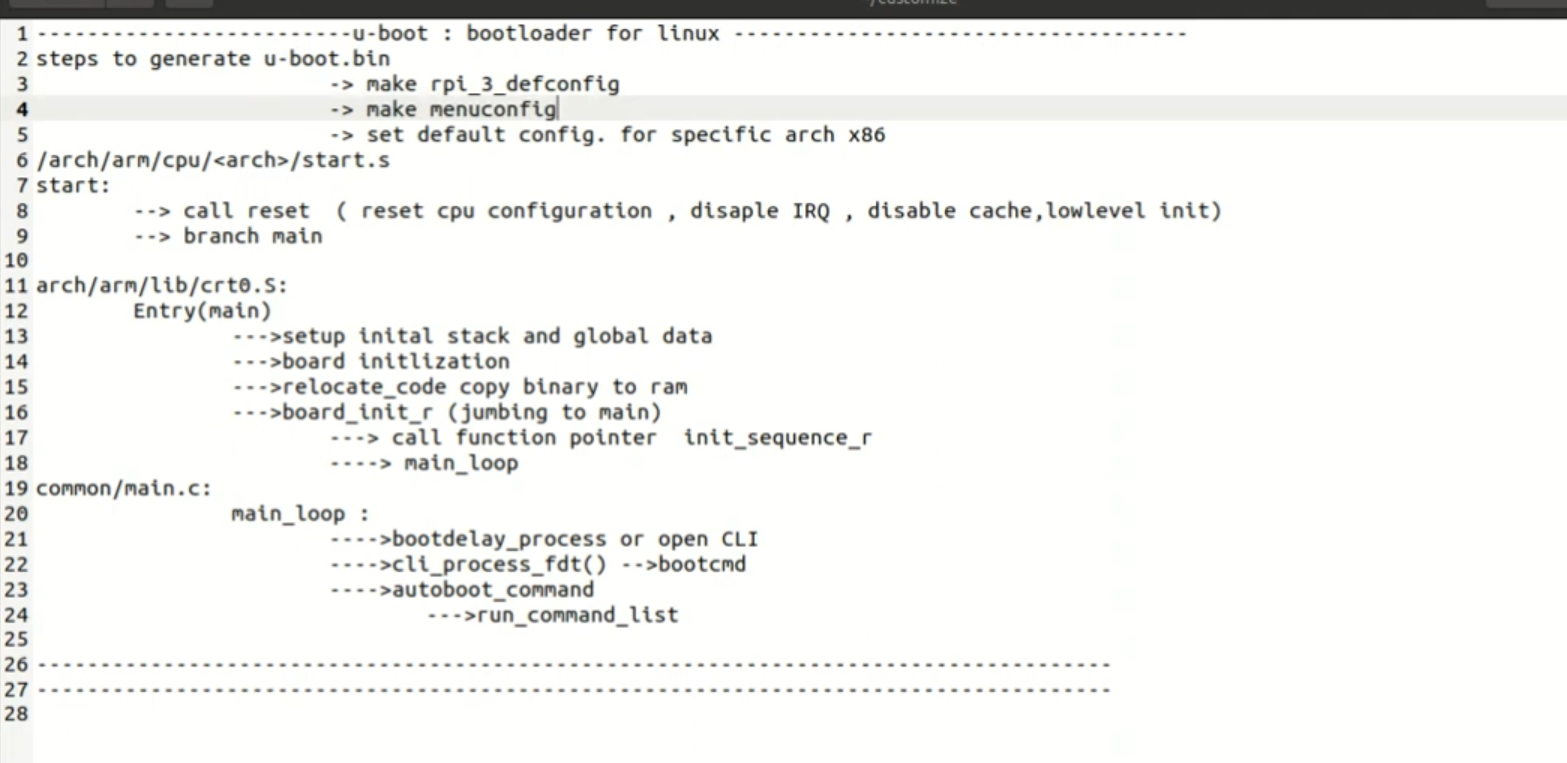

> For Raspberry Pi 4 (64-bit ARMv8 architecture) with the requirements you specified (Linux version 5.15.118, little endian, 64-bit, and GNU GCC 12.3.0), you can use U-Boot version 2023.10 or later. This version supports ARMv8 architecture and is compatible with the tools and kernel version you're using.

[u-boot source code](https://elixir.bootlin.com/u-boot/latest/sources) | [u-boot and kernel for raspi3b](https://github.com/Moatasem-Elsayed/Linux_Raspberrypi3b_image) | [U-boot steps for configuration](https://github.com/yusufsakr/RPI4_custom_image) | [config rpi4](https://andrei.gherzan.ro/linux/uboot-on-rpi/)


| **Feature**                           | **rpi_3_32b_defconfig**                  | **rpi_3_b_plus_defconfig**            | **rpi_3_defconfig**                 | **rpi_arm64_defconfig**             | **rpi_4_32b_defconfig**             | **rpi_4_defconfig**                |
|---------------------------------------|------------------------------------------|--------------------------------------|------------------------------------|------------------------------------|-----------------------------------|----------------------------------|
| **Target Platform**                   | Raspberry Pi 3 (32-bit)                  | Raspberry Pi 3 B+ (64-bit)            | Raspberry Pi 3 (64-bit)            | Raspberry Pi 3 and other ARMv8 boards (64-bit) | Raspberry Pi 4 (32-bit)             | Raspberry Pi 4 (64-bit)            |
| **CPU Architecture**                  | ARMv7 (32-bit)                           | ARMv8 (64-bit)                       | ARMv8 (64-bit)                     | ARMv8 (64-bit)                     | ARMv8 (32-bit)                     | ARMv8 (64-bit)                     |
| **CPU**                               | Broadcom BCM2837 (Cortex-A53)            | Broadcom BCM2837B0 (Cortex-A53)      | Broadcom BCM2837 (Cortex-A53)      | Generic ARMv8 (Cortex-A53)         | Broadcom BCM2711 (Cortex-A72)      | Broadcom BCM2711 (Cortex-A72)      |
| **Core Count**                        | 4 cores                                  | 4 cores                              | 4 cores                            | 4 cores                            | 4 cores                            | 4 cores                            |
| **CPU Frequency**                     | 1.2 GHz                                  | 1.4 GHz                              | 1.2 GHz                            | Configurable                       | 1.5 GHz                            | 1.5 GHz                            |
| **Memory**                            | 1 GB LPDDR2                              | 1 GB LPDDR2                          | 1 GB LPDDR2                        | Configurable                       | 2 GB, 4 GB, or 8 GB LPDDR4         | 2 GB, 4 GB, or 8 GB LPDDR4         |
| **Ethernet**                          | 10/100 Mbps                              | Gigabit Ethernet (USB 2.0)           | 10/100 Mbps                        | Configurable                       | Gigabit Ethernet                   | Gigabit Ethernet                   |
| **Wi-Fi**                             | 802.11n (Wi-Fi 4)                        | 802.11ac (Wi-Fi 5)                   | 802.11n (Wi-Fi 4)                  | Configurable                       | 802.11ac (Wi-Fi 5)                 | 802.11ac (Wi-Fi 5)                 |
| **Bluetooth**                         | Bluetooth 4.2                            | Bluetooth 4.2                        | Bluetooth 4.2                      | Configurable                       | Bluetooth 5.0                      | Bluetooth 5.0                      |
| **USB Ports**                         | 4 × USB 2.0                              | 4 × USB 2.0                          | 4 × USB 2.0                        | Configurable                       | 2 × USB 3.0, 2 × USB 2.0           | 2 × USB 3.0, 2 × USB 2.0           |
| **Display Interface**                 | DSI and HDMI                             | DSI and HDMI                         | DSI and HDMI                       | Configurable                       | DSI, HDMI, and MIPI-DSI            | DSI, HDMI, and MIPI-DSI            |
| **Camera Interface**                  | CSI interface                            | CSI interface                        | CSI interface                      | Configurable                       | CSI interface                      | CSI interface                      |
| **Boot Loader**                       | U-Boot for 32-bit Raspberry Pi 3         | U-Boot for Raspberry Pi 3 B+         | U-Boot for Raspberry Pi 3          | U-Boot for ARMv8 (64-bit)          | U-Boot for Raspberry Pi 4 (32-bit) | U-Boot for Raspberry Pi 4 (64-bit) |
| **Power Supply**                      | 5V/2.5A Micro USB                        | 5V/2.5A USB-C                        | 5V/2.5A Micro USB                  | Configurable                       | 5V/3A USB-C                        | 5V/3A USB-C                        |
| **Power-over-Ethernet (PoE)**         | Not supported                            | Supported (via separate HAT)         | Not supported                      | Configurable                       | Supported (via separate HAT)       | Supported (via separate HAT)       |
| **SD Card Support**                   | microSD                                   | microSD                               | microSD                             | microSD                            | microSD                             | microSD                             |
| **Kernel Support**                    | 32-bit kernel                            | 64-bit kernel                        | 64-bit kernel                       | 64-bit kernel                      | 32-bit kernel                       | 64-bit kernel                       |
| **Recommended Usage**                 | Raspberry Pi 3 (32-bit OS)               | Raspberry Pi 3 B+ (64-bit OS)         | Raspberry Pi 3 (64-bit OS)         | Generic ARMv8 boards (64-bit OS)  | Raspberry Pi 4 (32-bit OS)          | Raspberry Pi 4 (64-bit OS)          |
| **Microphone/Audio Recording Support** | Supported with external mic via USB or audio jack | Supported with external mic via USB or audio jack | Supported with external mic via USB or audio jack | Supported with external mic via USB or audio jack | Supported with external mic via USB or audio jack | Supported with external mic via USB or audio jack |



>**Raspberry Pi 3B:** Fully emulated in QEMU using the -M raspi3 machine type with ARMv7 (32-bit) and ARMv8 (64-bit) kernel configurations.
>
>**Raspberry Pi 3B+:** Limited support in QEMU, with more general emulation for the BCM2837B0 SoC. You can use the Raspberry Pi 3B emulation for most of the setup but may lack certain hardware features.
>


> We select **rpi_4_defconfig**

```bash

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ ls configs/ | grep rpi
    rpi_0_w_defconfig
    rpi_2_defconfig
    rpi_3_32b_defconfig
    rpi_3_b_plus_defconfig
    rpi_3_defconfig
    rpi_4_32b_defconfig
    rpi_4_defconfig
    rpi_arm64_defconfig
    rpi_defconfig

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ qemu-system-aarch64 -machine help | grep -i raspi
    raspi0               Raspberry Pi Zero (revision 1.2)
    raspi1ap             Raspberry Pi A+ (revision 1.1)
    raspi2b              Raspberry Pi 2B (revision 1.1)
    raspi3ap             Raspberry Pi 3A+ (revision 1.0)
    raspi3b              Raspberry Pi 3B (revision 1.2)
    raspi4b              Raspberry Pi 4B (revision 1.5)

    export CROSS_COMPILE=/home/ferganey/x-tools/aarch64-rpi4-linux-gnu/bin/aarch64-rpi4-linux-gnu-
    export ARCH=arm64
    export SYSROOT=$(aarch64-rpi4-linux-gnu-gcc -print-sysroot)

```


---
---


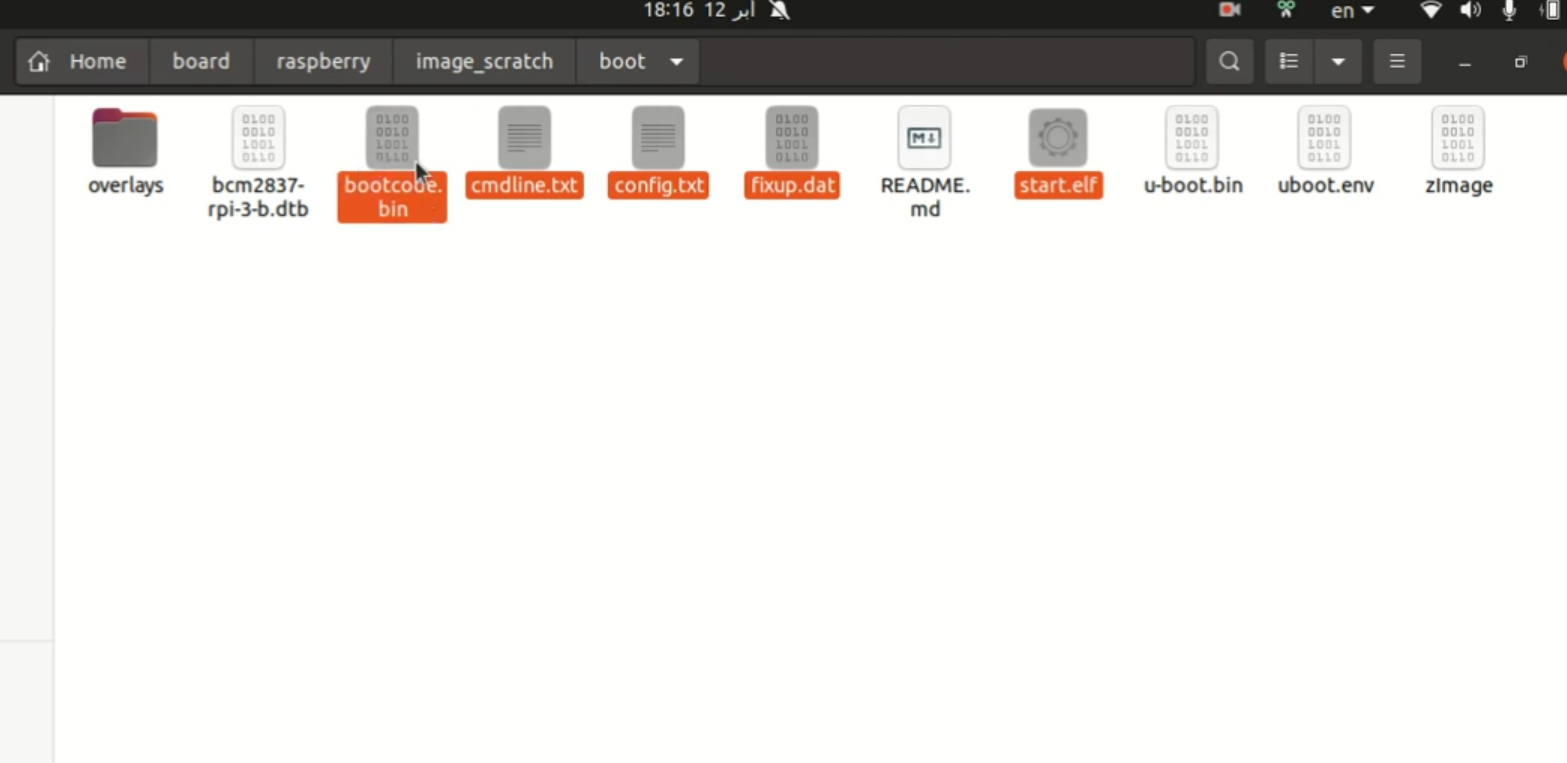
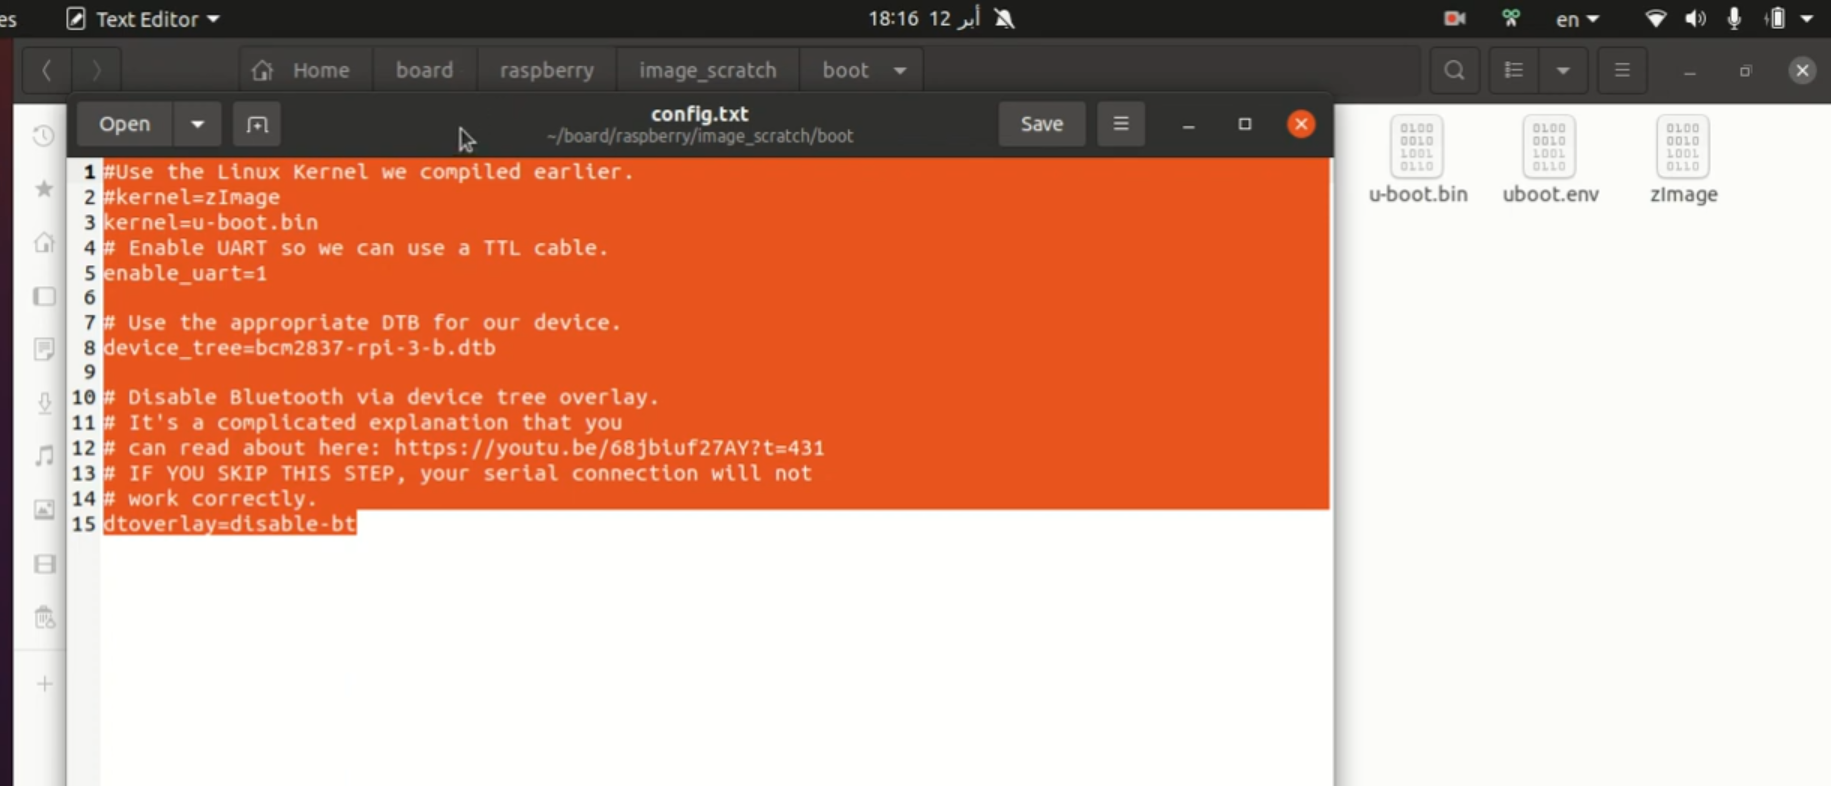
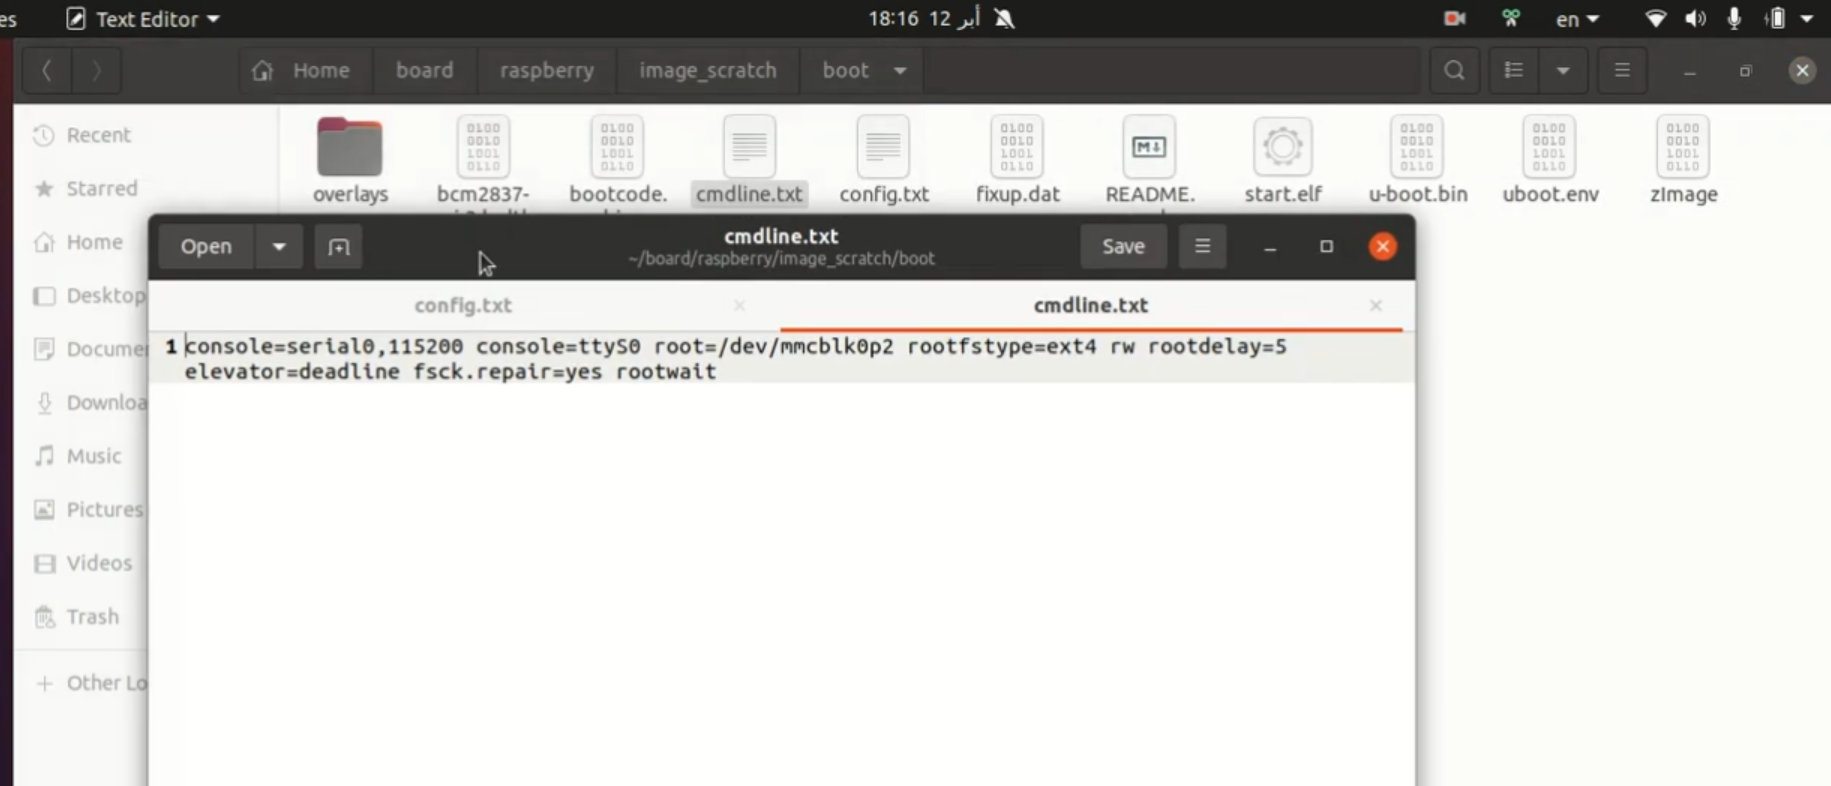

[Build a Raspberry Pi Linux System the Hard Way](https://rickcarlino.com/2021/build-a-raspbery-pi-linux-system-the-hard-way.html) | [step by step](https://github.com/yusufsakr/RPI4_custom_image)

```bash

ferganey@ferganey-linux:~$ cd ~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot


ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ ls configs/ | grep rpi
    rpi_4_defconfig

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader$ git clone https://source.denx.de/u-boot/u-boot.git

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader$ cd u-boot

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ git checkout v2023.10

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ export PATH=${HOME}/x-tools/aarch64-rpi4-linux-gnu/bin/:$PATH
ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ export CROSS_COMPILE=aarch64-rpi4-linux-gnu-

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ make rpi_4_defconfig
    aarch64-rpi4-linux-gnu-gcc (crosstool-NG 1.26.0) 12.3.0
    Copyright (C) 2022 Free Software Foundation, Inc.
    This is free software; see the source for copying conditions.  There is NO
    warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ make menuconfig
```
```plaintext
    - Update the device-tree stdout alias from U-Boot" --> Enable

    - Networking support -- >
         [*]   Enable generic udp framework  
         [*]   Enable bootdev for Ethernet if will use ethrnet for booting 
         [*]   Random ethaddr if unset "You may want to enable this if you're using virtual machines (like QEMU), as they often don't have a predefined MAC address."
             (16384) TFTP block size 
                For optimal performance in QEMU with a reliable network connection (bridged or tap), 16384 is often the best choice for faster transfers.
                8192 is a good compromise if you're dealing with moderate network conditions or memory usage concerns.
                1468 is safest for slower or more constrained networks, as it avoids fragmentation and ensures stability.  
             [*]   TCP stack 
             [*]     TCP SACK support 
             [*]   IPv6 support              
    - from command line interface --> Memory commands -- >  [*] strings - display strings in memory [*] md5sum [*] meminfo  

    - from boot media Support for booting from SD/EMMC ---> enable
    
    - from command line interface --> (u-boot: welcome ferganey> ) Shell prompt  

    - from boot options -->  [*] Enable boot arguments   ()    Boot arguments (NEW) 
        Example of Boot Arguments:

            root=/dev/mmcblk0p2: Tells the kernel where to find the root filesystem (in this case, on the second partition of an SD card).

            console=tty1: Specifies the primary console for kernel messages.

            init=/bin/bash: Specifies an alternate initialization program, like a shell, instead of the default init system.     
         Boot arguments --> setenv bootargs console=ttyAMA0,115200 root=/dev/mmcblk0p2 rootfstype=ext4 init=/bin/bash
saveenv

               
    - [*] Support substituting strings in boot arguments 
    
    - Boot commands
  │ │                   [*] bootd                                                                                 │ │  
  │ │                   [*] bootm                                                                                 │ │  
  │ │                   [*] bootdev                                                                               │ │  
  │ │                   [*] bootflow                                                                              │ │  
  │ │                   [ ] bootmeth                                                                              │ │  
  │ │                   [*] bootz                                                                                 │ │  
  │ │                   -*- booti                                                                                 │ │ 
  │ │                   [*] Support booting Linux OS images                                                       │ │  
  │ │                   [*] Support booting NetBSD (non-EFI) loader images                                        │ │  
  │ │                   [*] Support booting OPENRTOS / FreeRTOS images                                            │ │  
  │ │                   [ ] Support booting Enea OSE images                                                       │ │  
  │ │                   [ ] Support booting Plan9 OS images                                                       │ │  
  │ │                   [ ] Support booting RTEMS OS images                                                       │ │  
  │ │                   [ ] Support booting VxWorks OS images  



    - Imagepre-loadsupport --> [] Image pre-load support    []   Image pre-load signature support  

    - from autoboot option set delay for example --> 5

    - from autoboot option enable retry  [*] Boot retry feature -->  (3)   Timeout in seconds before attempting to boot again   (3)   Minimum timeout in seconds for 'bootretry' (NEW)    [*]   Reset the board to retry autoboot    
                                                                                              

```


```bash


ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ sudo apt install libncurses-dev libssl-dev libz-dev device-tree-compiler python3 libfdt-dev swig uuid-dev

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ make

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ sudo apt install minicom # will used later for hardware connectivity


ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ make tools

# if you faced issues in build or later you can,
ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ make distclean

```

# **Important configuration for custom application "Speech Recognition"**


When configuring U-Boot for the Raspberry Pi 3B in an autonomous vehicle application that involves running AI models (like Whisper) containerized with Docker, there are several critical configurations you need to consider. These configurations ensure support for 64-bit architecture, Docker compatibility, AI workloads, and hardware peripherals like audio input via a microphone.


```bash

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ ls
    arch   common     doc      examples  Kconfig   Makefile     scripts     u-boot      u-boot.map
    board  config.mk  drivers  fs        lib       net          System.map  u-boot.bin  u-boot-nodtb.bin

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ file u-boot
    u-boot: ELF 64-bit LSB executable, ARM aarch64, version 1 (SYSV), statically linked, with debug_info, not stripped


ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot$ file u-boot.bin
    u-boot.bin: PCX ver. 2.5 image data bounding box [8223, 54531] - [0, 8], 20-bit uncompressed

```

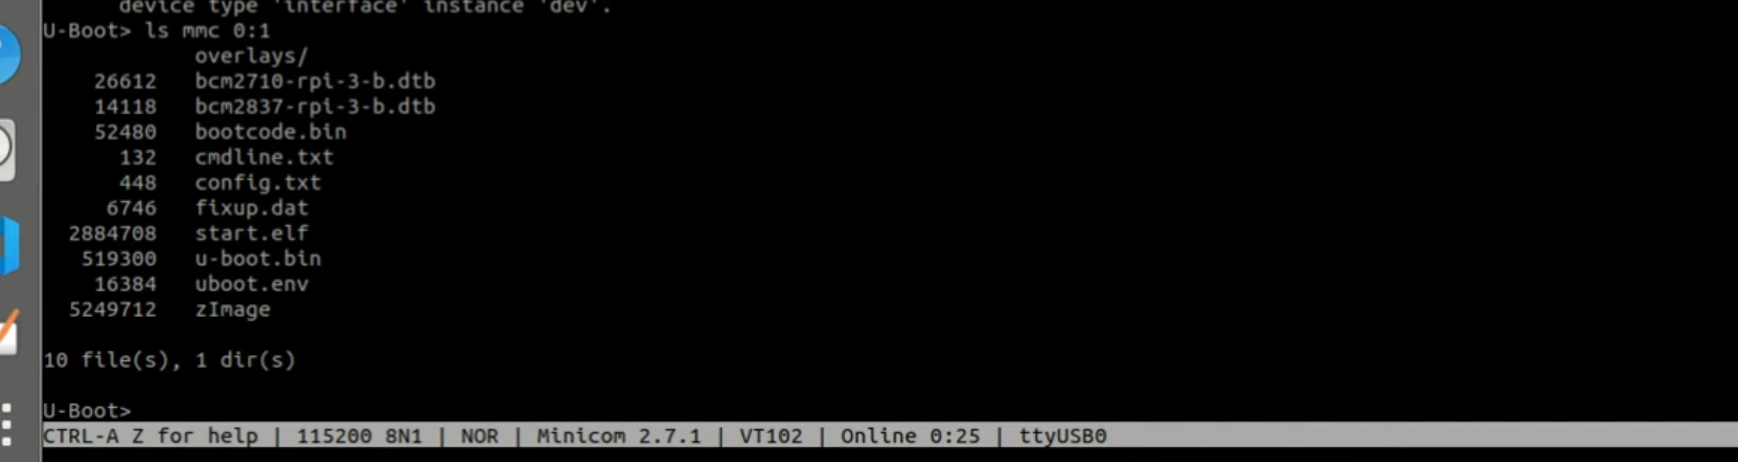


> Expected output from make u-boot -->
>   - u-boot.bin which transfered to boot/

> we will need also integrate at the same dir some other files 
>   - bootcode.bin
>   - cmdline.txt
>   - config.txt
>   - fixup.dat
>   - start.elf
>   - kernel7.img
>   - bcm2710-rpi-3-b.dtb
>   - u-boot.env



**the final output for raspi4 config file**
```plaintext
CONFIG_ARM=y
CONFIG_ARCH_BCM283X=y
CONFIG_TEXT_BASE=0x00080000
CONFIG_TARGET_RPI_4=y
CONFIG_HAS_CUSTOM_SYS_INIT_SP_ADDR=y
CONFIG_CUSTOM_SYS_INIT_SP_ADDR=0x7fffe30
CONFIG_ENV_SIZE=0x4000
CONFIG_DEFAULT_DEVICE_TREE="bcm2711-rpi-4-b"
CONFIG_OF_LIBFDT_OVERLAY=y
CONFIG_DM_RESET=y
CONFIG_SYS_LOAD_ADDR=0x1000000
CONFIG_PCI=y
CONFIG_BOOTSTD_DEFAULTS=y
CONFIG_OF_BOARD_SETUP=y
CONFIG_USE_PREBOOT=y
CONFIG_PREBOOT="pci enum; usb start;"
# CONFIG_DISPLAY_CPUINFO is not set
# CONFIG_DISPLAY_BOARDINFO is not set
CONFIG_MISC_INIT_R=y
CONFIG_FDT_SIMPLEFB=y
CONFIG_SYS_PROMPT="U-Boot> "
CONFIG_SYS_PBSIZE=1049
CONFIG_CMD_DFU=y
CONFIG_CMD_GPIO=y
CONFIG_CMD_MMC=y
CONFIG_CMD_PCI=y
CONFIG_CMD_USB=y
CONFIG_CMD_FS_UUID=y
CONFIG_ENV_FAT_DEVICE_AND_PART="0:1"
CONFIG_SYS_RELOC_GD_ENV_ADDR=y
CONFIG_ENV_VARS_UBOOT_RUNTIME_CONFIG=y
CONFIG_TFTP_TSIZE=y
CONFIG_DM_DMA=y
CONFIG_DFU_MMC=y
CONFIG_SYS_DFU_DATA_BUF_SIZE=0x100000
CONFIG_SYS_DFU_MAX_FILE_SIZE=0x200000
CONFIG_BCM2835_GPIO=y
CONFIG_MMC_SDHCI=y
CONFIG_MMC_SDHCI_SDMA=y
CONFIG_MMC_SDHCI_BCM2835=y
CONFIG_BCMGENET=y
CONFIG_PCI_BRCMSTB=y
CONFIG_PINCTRL=y
# CONFIG_PINCTRL_GENERIC is not set
CONFIG_DM_RNG=y
CONFIG_RNG_IPROC200=y
# CONFIG_REQUIRE_SERIAL_CONSOLE is not set
CONFIG_SYSINFO=y
CONFIG_SYSINFO_SMBIOS=y
CONFIG_USB=y
CONFIG_DM_USB_GADGET=y
CONFIG_USB_XHCI_HCD=y
CONFIG_USB_XHCI_PCI=y
CONFIG_USB_KEYBOARD=y
CONFIG_USB_GADGET=y
CONFIG_USB_GADGET_MANUFACTURER="FSL"
CONFIG_USB_GADGET_VENDOR_NUM=0x0525
CONFIG_USB_GADGET_PRODUCT_NUM=0xa4a5
CONFIG_USB_GADGET_DWC2_OTG=y
CONFIG_USB_GADGET_DOWNLOAD=y
CONFIG_VIDEO=y
# CONFIG_VIDEO_BPP8 is not set
# CONFIG_VIDEO_BPP16 is not set
CONFIG_SYS_WHITE_ON_BLACK=y
CONFIG_VIDEO_BCM2835=y
CONFIG_CONSOLE_SCROLL_LINES=10
CONFIG_PHYS_TO_BUS=y


# my configuration manually
CONFIG_ENV_SETTINGS="
    bootargs=console=ttyAMA0,115200 root=/dev/mmcblk0p2 rootfstype=ext4
    setenv bootargs console=ttyAMA0,115200 root=/dev/mmcblk0p2 rootfstype=ext4
"
CONFIG_CONSOLE_MUX=y
CONFIG_SYS_CONSOLE_INFO_QUIET=y
CONFIG_BOOTDELAY=3
CONFIG_BOOTRETRY=y
CONFIG_BOOTCMD="mmc dev 0; mmc read 0x1000000 0x800 0x4000; bootm 0x1000000"

```

---
---

**Linux Kernel**

[Raspberry-pi-4-model-b official specs](https://www.raspberrypi.com/products/raspberry-pi-4-model-b/specifications/)

> bcm2711_defconfig	Raspberry Pi 4, Compute Module 4	ARMv8 64-bit

[Johannes 4GNU_Linux](https://www.youtube.com/@johannes4gnu_linux96/playlists) | [Johannes4Linux Github](https://github.com/Johannes4Linux) | [Moatassam El  sayed](https://www.youtube.com/watch?v=xAvswOlQMP0&list=PLkH1REggdbJpFXAzQqpjZgV1oghPsf9OH&index=20) | [raspi linux github](https://github.com/raspberrypi/linux)

> other resources 
[bcmrpi3](https://github.com/sakaki-/bcmrpi3-kernel) | [raspberrypi](https://www.raspberrypi.com/documentation/computers/linux_kernel.html) | [vaporator_system_rpi3](https://hexdocs.pm/vaporator_system_rpi3/readme.html) | [configure-the-kernel](https://www.raspberrypi.com/documentation/computers/linux_kernel.html#configure-the-kernel)

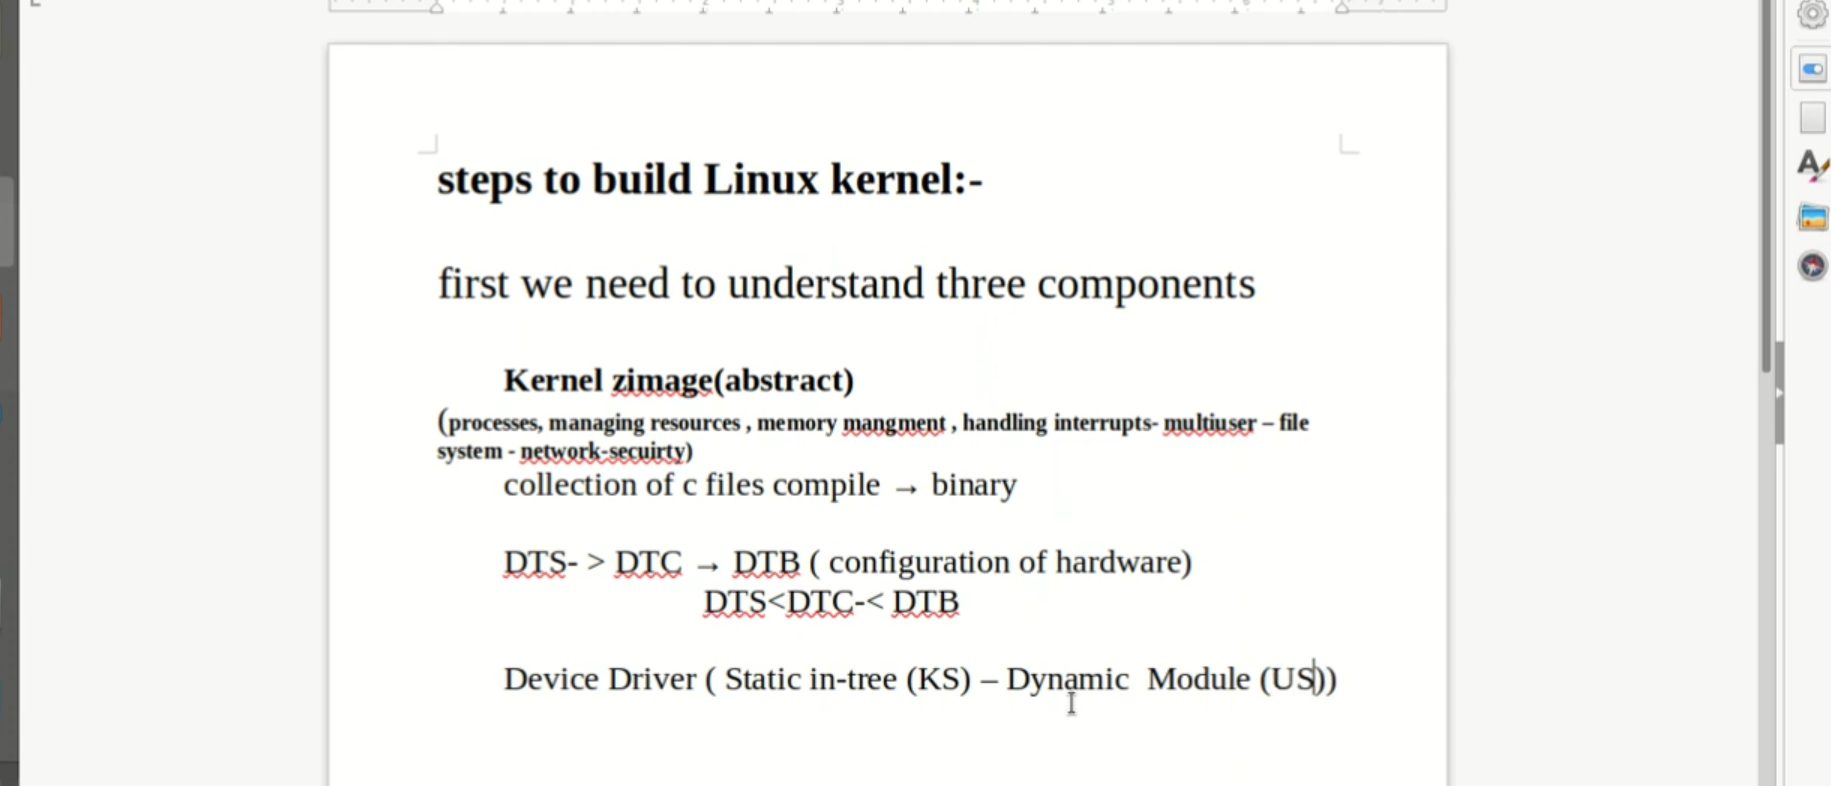

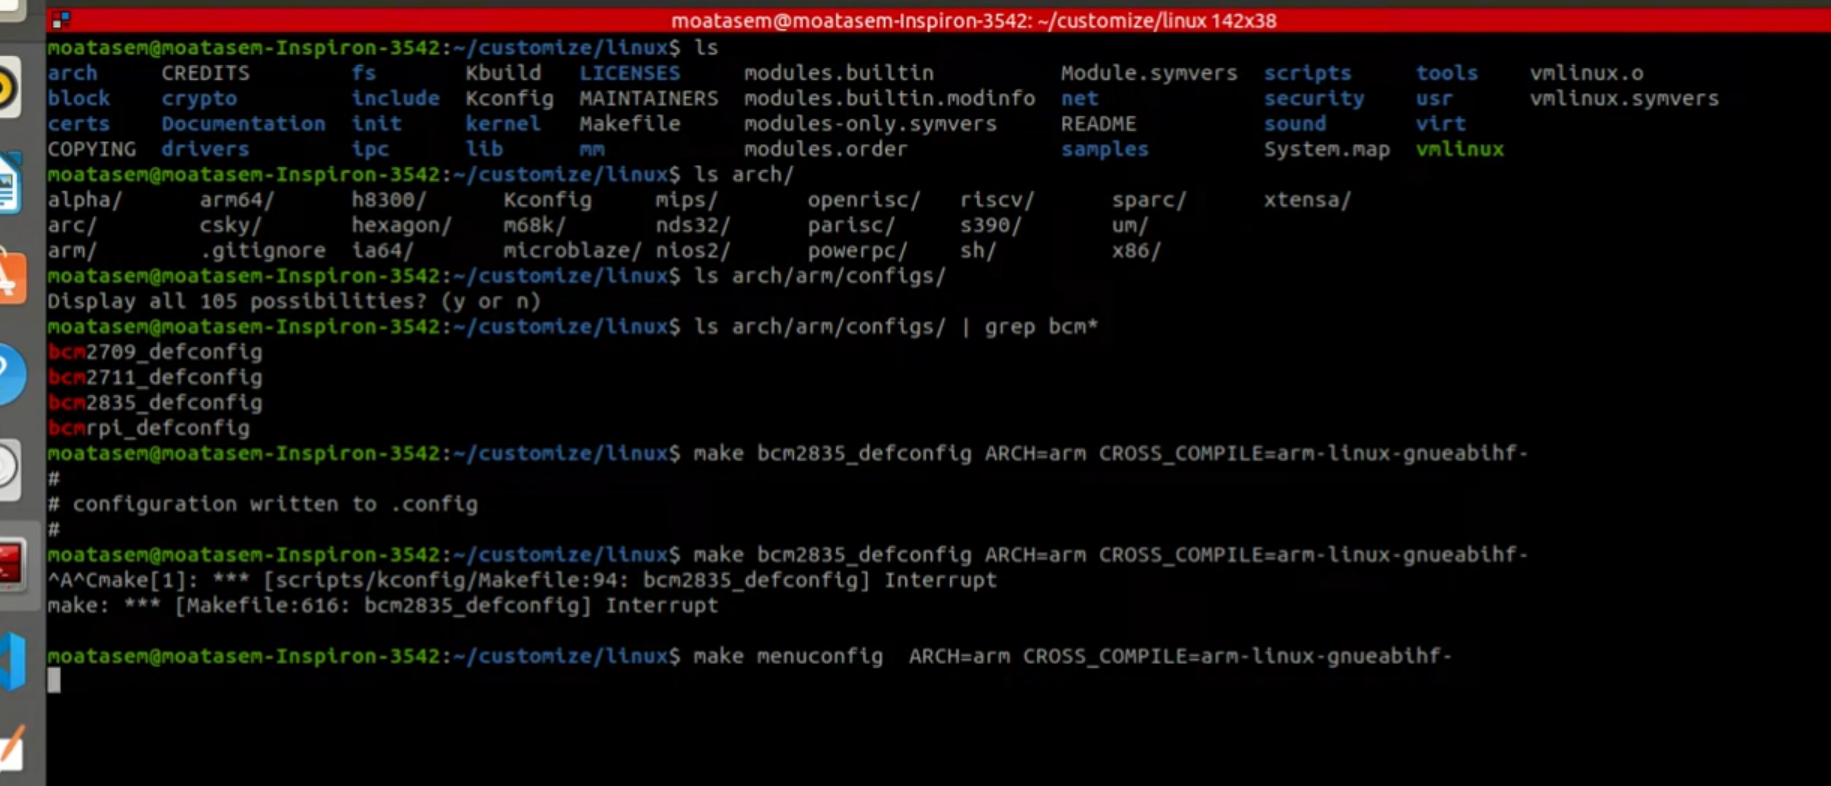

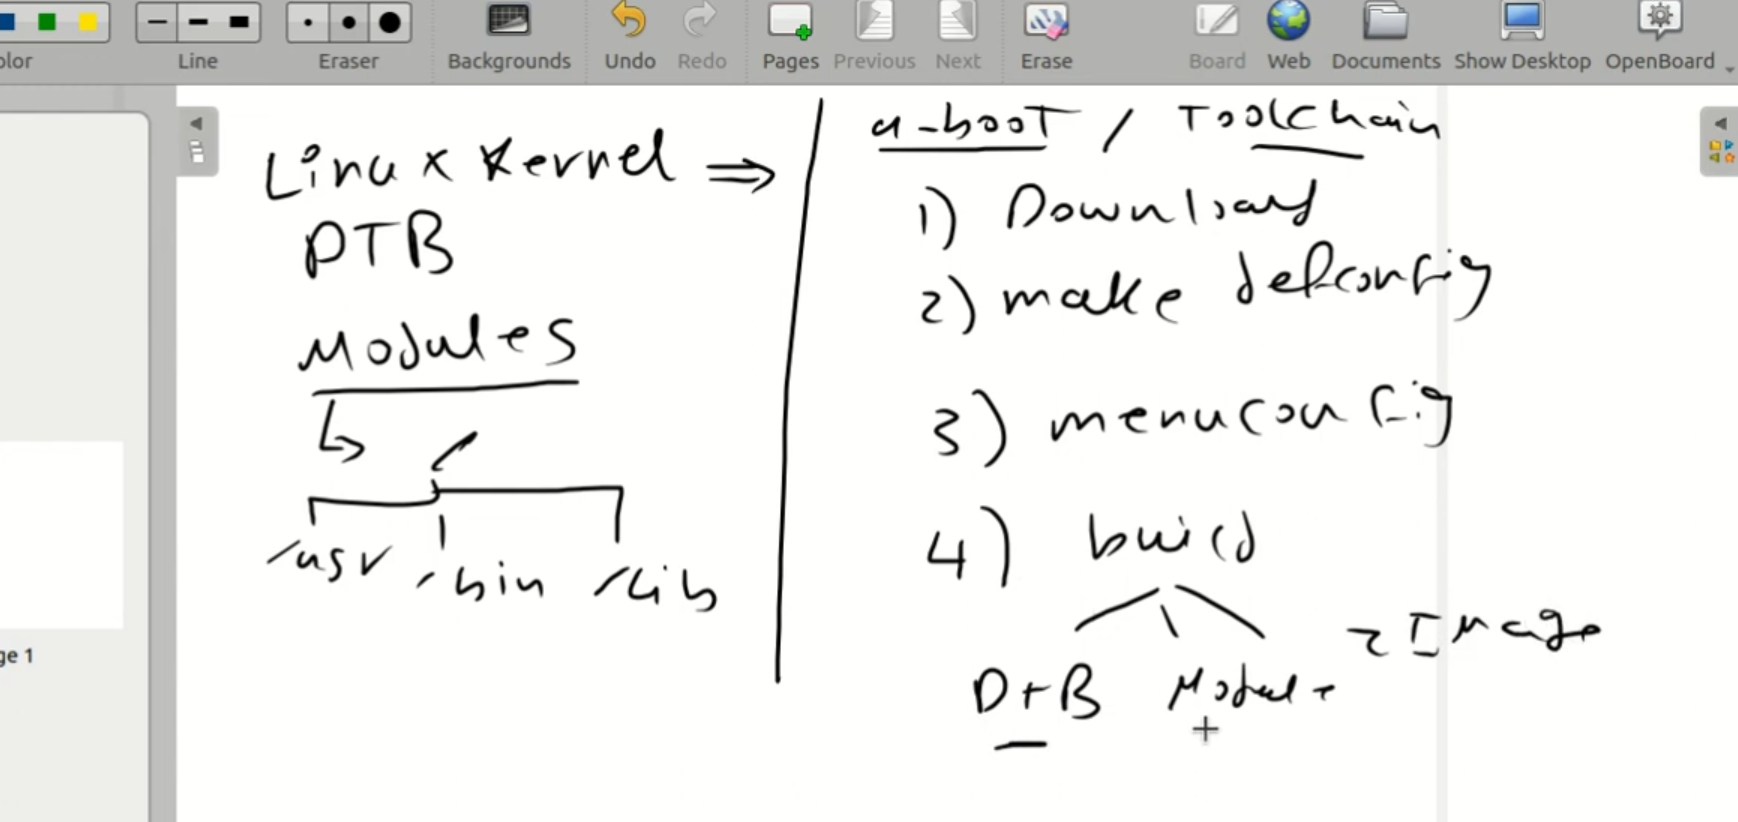

> Recomendded 6.1.58

```bash
ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/kernel/Raspi_Linux$ git clone https://github.com/raspberrypi/linux

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/kernel/Raspi_Linux$ cd ./linux

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/kernel/Raspi_Linux/linux$ ls ./arch/arm64/configs
    {
        bcm2711_defconfig  bcmrpi3_defconfig  defconfig
    }
    bcm2709_defconfig            
    bcm2711_defconfig                          
    bcm2835_defconfig                         
    bcmrpi_defconfig                        
    versatile_defconfig
    vexpress_defconfig
    bcm2837_defconfig
{
    (https://www.raspberrypi.com/documentation/computers/linux_kernel.html)
    cd linux
    KERNEL=kernel8
    make bcm2711_defconfig
}

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/kernel/Raspi_Linux/linux$ git checkout  -b rpi-5.15.y


# we will specify kernel in config.txt later
# ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/kernel/Raspi_Linux/linux$ KERNEL=kernel8 


ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/kernel/Raspi_Linux/linux$ make ARCH=arm64 CROSS_COMPILE=aarch64-rpi4-linux-gnu- bcm2711_defconfig

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/kernel/Raspi_Linux/linux$ make ARCH=arm64 CROSS_COMPILE=aarch64-rpi4-linux-gnu- menuconfig 
```
```plaintext
 < > PCCard (PCMCIA/CardBus) support  ----  
 USB support -- > <M>   EHCI HCD (USB 2.0) support ,   <*>   EMI 6|2m USB Audio interface support , <*>   EMI 2|6 USB Audio interface support  
   Kernel command line type (Use bootloader kernel arguments if available)  --->  (X) Use bootloader kernel arguments if available  
  [*] Energy Model for devices with DVFS (CPUs, GPUs, etc)   
   VGA Arbitration  -- >(1)   Maximum number of GPUs  
    Kernel Features  --> (4) Maximum number of CPUs (2-4096) , Timer frequency (300 HZ)

Device Drivers → Staging Drivers → Realtek RTL8188EU Wireless LAN NIC driver  "Deselect (< >) this driver."
     Raspi4 has built-in Wi-Fi and Bluetooth via the CYW43455 chip, which does not require the r8188eu driver. You only need the r8188eu if you're connecting an external USB Wi-Fi adapter with the Realtek RTL8188EU chipset.

  │ │                   <*> Overlay filesystem support                                                            │ │  
  │ │                   (rpi4:ferganey) Default hostname                                                          │ │  

  │ │                   [*] Multi-core scheduler support                                                          │ │  

```
```
Summary:

    - Set Maximum number of CPUs to 4.

    - Ensure Broadcom drivers (brcmfmac, btusb, GENET) are enabled.

    - Disable drivers like r8188eu unless explicitly needed for external devices.

    - Enable CONFIG_DRM_VC4 for graphics and media acceleration.

    - If you're using a PoE HAT, make sure the PoE-related drivers are enabled.


```

```bash
# ensure that 

# ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/kernel/Raspi_Linux/linux$ nano ~/.bashrc
# export INSTALL_MOD_PATH=/home/ferganey/Embedded_Systems/other_resources/practical/Rpi4
# source ~/.bashrc


ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/kernel/Raspi_Linux/linux$ make -j$(nproc) Image.gz modules dtbs ARCH=arm64 CROSS_COMPILE=aarch64-rpi4-linux-gnu-


ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/kernel/Raspi_Linux/linux$ make INSTALL_MOD_PATH=/home/ferganey/Embedded_Systems/other_resources/practical/Rpi4  ARCH=arm64 CROSS_COMPILE=aarch64-rpi4-linux-gnu- modules_install 

# if you need rebuild :
ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/kernel/Raspi_Linux/linux$ make ARCH=arm64 CROSS_COMPILE=aarch64-rpi4-linux-gnu- clean
ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/kernel/Raspi_Linux/linux$ make ARCH=arm64 CROSS_COMPILE=aarch64-rpi4-linux-gnu- mrproper
    ## then repeat steps from above

```

---
---

**Busy Box**

[BusyBox RasPi3B](https://nayab.xyz/rpi3b-elinux/embedded-linux-rpi3-060-busybox.html) | [BusyBox Official](https://www.busybox.net/)

> **Busybox** is a software suite, that generates **a minimal root file system** with an init program, the shell and basic Linux utilities.



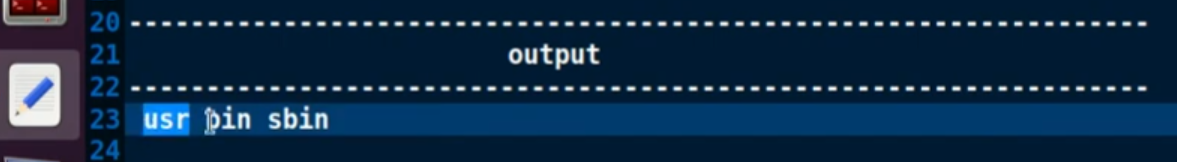



```bash

ferganey@ferganey-linux:~/Embedded_Systems$ git clone git://busybox.net/busybox.git

ferganey@ferganey-linux:~/Embedded_Systems/busybox$ cd busybox

ferganey@ferganey-linux:~/Embedded_Systems/busybox$ mkdir output && cd ./output && mkdir minimal_root && cd ./minimal_root

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/busybox$ git checkout 1_36_1


# # the next step is critical
ferganey@ferganey-linux:~/Embedded_Systems/busybox$ CROSS_COMPILE=${HOME}/x-tools/aarch64-rpi4-linux-gnu/bin/aarch64-rpi4-linux-gnu-

ferganey@ferganey-linux:~/Embedded_Systems/busybox$ make CROSS_COMPILE="$CROSS_COMPILE" defconfig

# ferganey@ferganey-linux:~/Embedded_Systems/busybox$  sed -i 's%^CONFIG_PREFIX=.*$%CONFIG_PREFIX="./output/minimal_root"%' .config


ferganey@ferganey-linux:~/Embedded_Systems/busybox$ make CROSS_COMPILE="$CROSS_COMPILE" menuconfig 

    Settings -> Build static binary 	(no shared libraries) 	Enable
    Settings -> Cross compiler prefix 	CROSS_COMPILE=aarch64-rpi4-linux-gnu-
    Settings -> Destination path for ‘make install’ 	Same as INSTALL_MOD_PATH from kernel modules ste  ---> ./output/minimal_root

# ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/busybox$  curl https://www.nayab.xyz/patches/0003-compile-error-fix-stime.patch --output ./0003-compile-error-fix-stime.patch

# ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/busybox$  git apply 0003-compile-error-fix-stime.patch


ferganey@ferganey-linux:~/Embedded_Systems/busybox$ make CROSS_COMPILE="$CROSS_COMPILE"

ferganey@ferganey-linux:~/Embedded_Systems/busybox$ sudo make  CROSS_COMPILE="$CROSS_COMPILE" install

    # Static linking against glibc, can't use --gc-sections
    # Trying libraries: m resolv rt
    # Library m is needed, can't exclude it (yet)
    # Library resolv is needed, can't exclude it (yet)
    # Library rt is not needed, excluding it
    # Library m is needed, can't exclude it (yet)
    # Library resolv is needed, can't exclude it (yet)
    # Final link with: m resolv


```



---

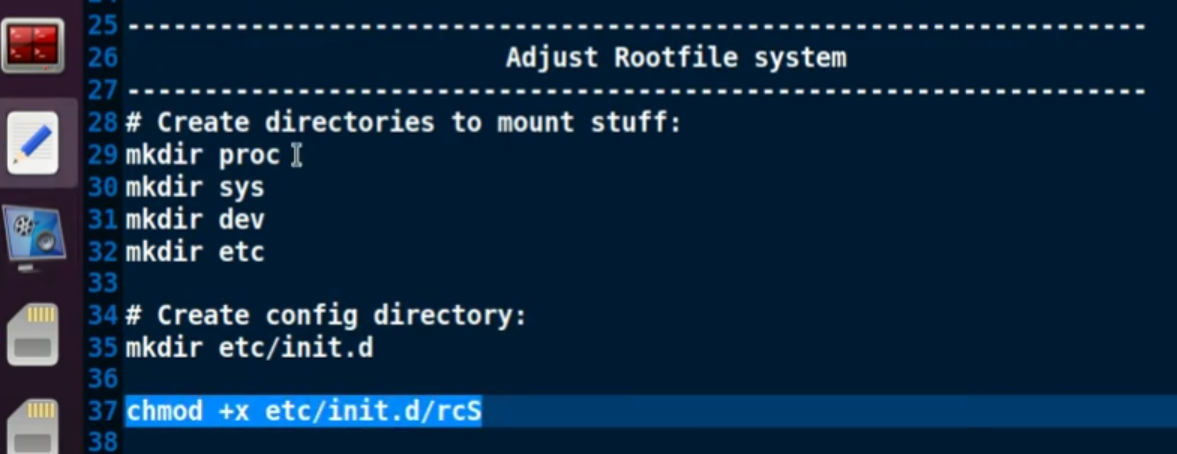

```bash
mkdir etc/init.d
touch etc/init.d/rcS
chmod +x etc/init.d/rcS
```

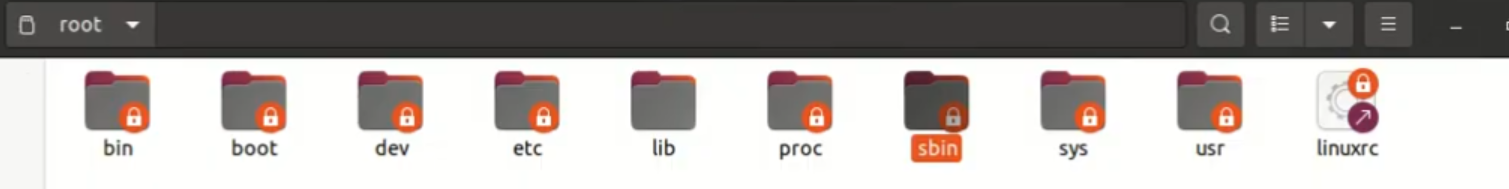
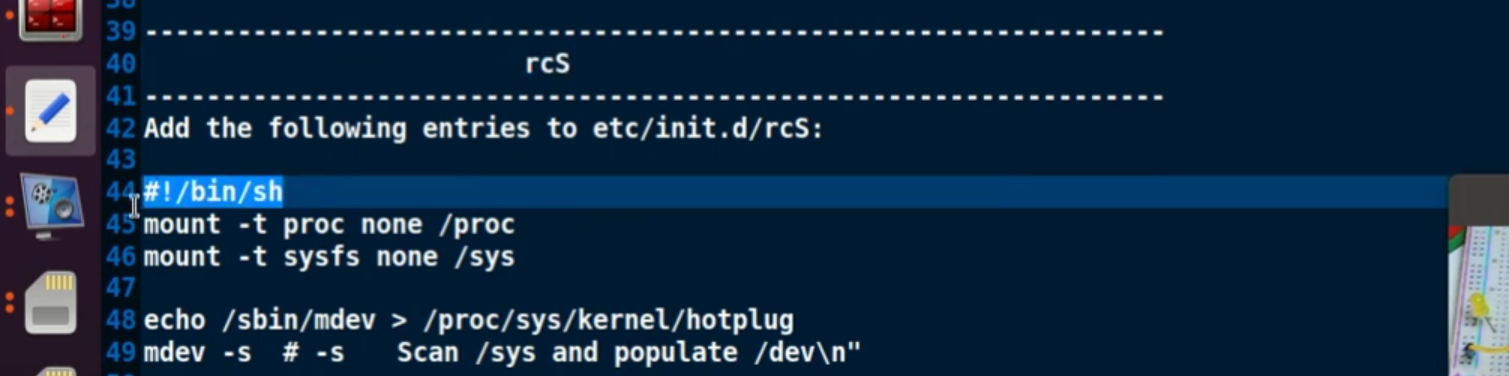

```bash
#!/bin/sh
mount -t proc none /proc
mount -t sysfs none /sys

echo /sbin/mdev > /proc/sys/kernel/hotplug
mdev -s  # -s	Scan /sys and populate /dev\n"
```

> Copy lib that gained via building kernel


**setup additional files**


```bash
ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ sudo touch boot.cmd

ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ sudo nano boot.cmd
{
# Set kernel boot arguments for Raspberry Pi 4
# - console=serial0,115200 for UART debugging
# - root=/dev/mmcblk0p2 for SD card root filesystem
# - earlyprintk and loglevel=7 for detailed boot logs
# - init=/sbin/init or /bin/sh for initial process
setenv bootargs "console=serial0,115200 root=/dev/mmcblk0p2 rootfstype=ext4 rw earlyprintk loglevel=7 init=/bin/sh"

# Load the raw kernel image from SD card
load mmc 0:1 0x80000 /boot/Image

# Load the device tree blob (DTB) for Raspberry Pi 4
load mmc 0:1 0x2000000 /boot/bcm2711-rpi-4-b.dtb

# Boot the kernel with the device tree blob (no initrd used)
booti 0x80000 - 0x2000000

}

ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ which mkimage
   /home/ferganey/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot/tools/mkimage

ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ sudo ln -s /home/ferganey/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot/tools/mkimage /usr/local/bin/mkimage
ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ sudo mkimage -A arm -T script -C none -n "Boot Script" -d ./boot.cmd ./boot.scr
Image Name:   Boot Script
Created:      Sun Dec 29 02:58:22 2024
Image Type:   ARM Linux Script (uncompressed)
Data Size:    198 Bytes = 0.19 KiB = 0.00 MiB
Load Address: 00000000
Entry Point:  00000000
Contents:
   Image 0: 190 Bytes = 0.19 KiB = 0.00 MiB
ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ 


ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ 
 hexdump -C /home/ferganey/Embedded_Systems/Autonomous_Vhehicle_GradProject/boot.scr
```
```plaintext
{
00000000  27 05 19 56 e2 87 bc 29  67 6e 1b a8 00 00 00 bf  |'..V...)gn......|
00000010  00 00 00 00 00 00 00 00  4e 42 ea 3a 05 02 06 00  |........NB.:....|
00000020  42 6f 6f 74 20 53 63 72  69 70 74 00 00 00 00 00  |Boot Script.....|
00000030  00 00 00 00 00 00 00 00  00 00 00 00 00 00 00 00  |................|
00000040  00 00 00 b7 00 00 00 00  73 65 74 65 6e 76 20 62  |........setenv b|
00000050  6f 6f 74 61 72 67 73 20  63 6f 6e 73 6f 6c 65 3d  |ootargs console=|
00000060  74 74 79 53 30 2c 31 31  35 32 30 30 20 72 6f 6f  |ttyS0,115200 roo|
00000070  74 3d 2f 64 65 76 2f 6c  6f 6f 70 31 38 70 32 20  |t=/dev/loop18p2 |
00000080  72 6f 6f 74 66 73 74 79  70 65 3d 65 78 74 34 20  |rootfstype=ext4 |
00000090  72 6f 6f 74 77 61 69 74  0a 6c 6f 61 64 20 6d 6d  |rootwait.load mm|
000000a0  63 20 30 3a 31 20 30 78  38 30 30 30 20 2f 62 6f  |c 0:1 0x8000 /bo|
000000b0  6f 74 2f 49 6d 61 67 65  0a 6c 6f 61 64 20 6d 6d  |ot/Image.load mm|
000000c0  63 20 30 3a 31 20 30 78  31 30 30 30 30 20 2f 62  |c 0:1 0x10000 /b|
000000d0  6f 6f 74 2f 62 63 6d 32  37 31 31 2d 72 70 69 2d  |oot/bcm2711-rpi-|
000000e0  34 2d 62 2e 64 74 62 0a  62 6f 6f 74 69 20 30 78  |4-b.dtb.booti 0x|
000000f0  38 30 30 30 20 2d 20 30  78 31 30 30 30 30 0a     |8000 - 0x10000.|
000000ff
}
```


---
---

**SD-Card and Automoate Copying**

[links issue ](https://forums.raspberrypi.com/viewtopic.php?t=364131#:~:text=This%20makes%20sense%20because%20fat32,create%20new%20links%20as%20well.)



```bash
#!/bin/bash

# Variables
SD_IMAGE="sd.img"
MOUNT_DIR="./mnt"
BOOT_PART="$MOUNT_DIR/boot"
ROOTFS_PART="$MOUNT_DIR/rootfs"
RPi_REPO="/home/ferganey/Embedded_Systems/Autonomous_Vhehicle_GradProject/rpirepo"
KERNEL_DIR="/home/ferganey/Embedded_Systems/other_resources/practical/embedded-linux-labs/kernel/Raspi_Linux/linux"
BUSYBOX_DIR="/home/ferganey/Embedded_Systems/busybox"
OUTPUT_DIR="/home/ferganey/Embedded_Systems/busybox/output/minimal_root"
UBOOT_DIR="/home/ferganey/Embedded_Systems/other_resources/practical/embedded-linux-labs/bootloader/u-boot"
MODULES_DIR="/home/ferganey/Embedded_Systems/other_resources/practical/Rpi4/lib/modules/5.15.92-v8+"


# Function to check command success
check_error() {
    if [ $? -ne 0 ]; then
        echo "Error during: $1. Exiting."
        exit 1
    fi
}

# Check for required commands
REQUIRED_CMDS=(dd parted losetup mkfs.vfat mkfs.ext4 mount cp mkdir)
for cmd in "${REQUIRED_CMDS[@]}"; do
    command -v $cmd > /dev/null || { echo "$cmd not found. Please install it."; exit 1; }
done

# Ensure directory permissions
ensure_directory() {
    local dir="$1"
    if [ ! -d "$dir" ]; then
        echo "$dir does not exist. Creating it..."
        mkdir -p "$dir"
        check_error "creating $dir"
    fi

    if [ ! -r "$dir" ] || [ ! -w "$dir" ]; then
        echo "Ensuring read and write permissions for $dir..."
        sudo chmod -R u+rw "$dir"
        sudo chown -R $(whoami):$(whoami) "$dir"
        check_error "setting permissions for $dir"
    fi
}

# Ensure permissions for required directories
ensure_directory "$MOUNT_DIR"
ensure_directory "$BOOT_PART"
ensure_directory "$ROOTFS_PART"

# Create SD card image
echo "Creating SD card image..."
sudo dd if=/dev/zero of=$SD_IMAGE bs=1M count=16384 status=progress
check_error "creating SD card image"


# Partition the SD card image
echo "partitioning SD card image..."
sudo parted $SD_IMAGE --script mklabel msdos
sudo parted $SD_IMAGE --script mkpart primary fat32 1MiB 256MiB
sudo parted $SD_IMAGE --script mkpart primary ext4 256MiB 100%
sudo parted $SD_IMAGE --script set 1 boot on
check_error "partitioning SD card image"

# Map the SD card image to loop devices
echo "Mapping SD card image to loop devices..."
LOOP_DEVICE=$(sudo losetup -Pf --show $SD_IMAGE)
check_error "mapping SD card image"
echo "Mapped to $LOOP_DEVICE"

# Format the partitions
echo "Formatting partitions..."
sudo mkfs.vfat -F 32 -n boot ${LOOP_DEVICE}p1
check_error "formatting boot partition"
sudo mkfs.ext4 -L root ${LOOP_DEVICE}p2
check_error "formatting root partition"

# Mount the partitions
echo "Mounting partitions..."
sudo mount ${LOOP_DEVICE}p1 $BOOT_PART
check_error "mounting boot partition"
sudo mount ${LOOP_DEVICE}p2 $ROOTFS_PART
check_error "mounting root partition"

# Verify mounts
echo "Verifying mounts..."
findmnt -M $BOOT_PART > /dev/null || { echo "$BOOT_PART is not mounted."; exit 1; }
findmnt -M $ROOTFS_PART > /dev/null || { echo "$ROOTFS_PART is not mounted."; exit 1; }


# Copy boot files
# https://github.com/raspberrypi/firmware/tree/stable/boot
echo "Copying boot files..."
sudo cp $RPi_REPO/{bootcode.bin,start4.elf,fixup4.dat} $BOOT_PART/
check_error "copying boot files"

# Create cmdline.txt
echo "Creating cmdline.txt..."
echo "console=ttyS0,115200 root=/dev/loop17p2 rootfstype=ext4 fsck.repair=yes rootwait" | sudo tee "$BOOT_PART/cmdline.txt" > /dev/null
check_error "creating cmdline.txt"
# This option is used for outputting the boot messages to the first serial port (ttyS0), which could be connected to a serial terminal or a serial debug console.

# Create config.txt
# Create config.txt
echo "Creating config.txt..."
cat <<EOF | sudo tee "$BOOT_PART/config.txt" > /dev/null
# Enable support for ARM 64-bit
arm_64bit=1

# Set up the device tree file for Raspberry Pi 4
device_tree=bcm2711-rpi-4-b.dtb

# Set the boot partition location for a Raspberry Pi 4
# This tells the Pi to boot from the first FAT partition (usually where the kernel is)
boot_partition=0

# Boot mode options
root=/dev/loop17p2
rootfstype=ext4

# Use the Linux Kernel we compiled earlier (usually u-boot or a specific kernel image)
kernel=u-boot.bin  # Or specify the kernel image if you use a specific one (e.g., /boot/kernel7l.img)

# Enable UART serial console for debugging
enable_uart=1

# Disable Bluetooth in QEMU (useful for serial connection to work correctly in QEMU environment)
dtoverlay=disable-bt

# GPU memory setting for graphics
gpu_mem=512

# Uncomment to enable HDMI output (if needed)
# hdmi_force_hotplug=1
EOF
check_error "creating config.txt"


# Copy kernel and device tree files
echo "copying kernel, U-Boot, and device tree files..."
sudo cp $KERNEL_DIR/arch/arm64/boot/Image $BOOT_PART/
sudo cp $KERNEL_DIR/arch/arm64/boot/dts/broadcom/bcm2711-rpi-4-b.dtb $BOOT_PART/
sudo cp -r $KERNEL_DIR/arch/arm64/boot/dts/overlays $BOOT_PART/
sudo cp $UBOOT_DIR/u-boot.bin $BOOT_PART/
check_error "copying kernel, U-Boot, and device tree files"


echo "Copying overlays..."

# Ensure the target directory exists
sudo mkdir -p $BOOT_PART/overlays

# Copy the overlays using rsync, and suppress ownership and group errors
sudo rsync -av --copy-links --no-owner --no-group $KERNEL_DIR/arch/arm64/boot/dts/overlays/  $BOOT_PART/overlays/

# Check if the rsync command was successful
if [ $? -eq 0 ]; then
    echo "Overlays copied successfully."
else
    echo "Error: Failed to copy overlays."
fi

# Set up root filesystem
echo "Setting up root filesystem..."
sudo mkdir -p $ROOTFS_PART/{lib,etc,tmp,proc,sys,dev,home,lib64,run,usr/{bin,lib,sbin},var/log}
sudo rsync -a $OUTPUT_DIR/ $ROOTFS_PART/
check_error "setting up root filesystem"

# Copy shared libraries if needed
STATIC_CHECK=$(file $BUSYBOX_DIR/bin/busybox | grep "statically linked")
if [ -z "$STATIC_CHECK" ]; then
    echo "Copying shared libraries..."
    SYSROOT=$(aarch64-rpi4-linux-gnu-gcc -print-sysroot)
    sudo cp -rL ${SYSROOT}/lib/* $ROOTFS_PART/lib/
    sudo cp -rL ${SYSROOT}/lib64/* $ROOTFS_PART/lib64/
    sudo cp -rL ${SYSROOT}/usr/lib/* $ROOTFS_PART/usr/lib/
    check_error "copying shared libraries"
else
    echo "BusyBox is statically linked. Skipping shared libraries."
fi

# Copy optional binaries
echo "copying cross-toolchain binaries..."
sudo cp -r /home/ferganey/x-tools/aarch64-rpi4-linux-gnu/bin/* $ROOTFS_PART/usr/bin/
check_error "copying cross-toolchain binaries"

# Copy kernel modules
if [ -d "$MODULES_DIR" ]; then
    echo "Copying kernel modules..."
    sudo mkdir -p $ROOTFS_PART/lib/modules
    sudo cp -r $MODULES_DIR/* $ROOTFS_PART/lib/modules/
    check_error "copying kernel modules"
fi

# Final setup
sudo mknod -m 666 $ROOTFS_PART/dev/null c 1 3
sudo mknod -m 600 $ROOTFS_PART/dev/console c 5 1
check_error "creating device nodes"

# Unmount and clean up
echo "Unmounting and cleaning up..."
# sudo umount $BOOT_PART
# sudo umount $ROOTFS_PART
# sudo losetup -d $LOOP_DEVICE

echo "SD card image created successfully with BusyBox for Raspberry Pi 4B!"

```

---
---

**Debugging**

[file structure](https://iotstarters.com/understanding-raspberry-pi-file-system/) 


> **cmdline.txt** This file is used to specify kernel parameters for booting, such as the console output, root filesystem, etc. If you're using U-Boot

> **config.txt** This is where Raspberry Pi-specific configurations are set (e.g., enabling/disabling hardware, setting kernel parameters). If you're using U-Boot, this file may be used less frequently, but you might still need it for other settings

> **Overlays** Ensure any device tree overlays you need are placed in the overlays/ directory. Overlays are used to add support for peripherals (e.g., display drivers, sound cards).

> **Device Tree** bcm2711-rpi-4-b.dtb, which is the device tree binary for Raspberry Pi 4. Ensure that U-Boot can load the device tree with the kernel.

> **boot.scr** If you want U-Boot to automate the boot process (e.g., loading the kernel, passing parameters, etc.), you can write a U-Boot script and place it in /boot/.



> **Comparison of U-Boot Boot Scripts**

     - Script 1:

```bash
setenv bootargs console=ttyS0,115200 root=/dev/loop18p2 rootfstype=ext4 rootwait
load mmc 0:1 0x8000 /boot/Image
load mmc 0:1 0x10000 /boot/bcm2711-rpi-4-b.dtb
booti 0x8000 - 0x10000
```
     - Script 2:
```bash     
setenv bootargs console=ttyS0,115200 root=/dev/loop18p2 rootfstype=ext4 rootwait
load mmc 0:1 0x1000000 /boot/Image
load mmc 0:1 0x2000000 /boot/bcm2711-rpi-4-b.dtb
bootz 0x1000000 - 0x2000000
```

| Feature                      | Script 1 (`booti`)                                  | Script 2 (`bootz`)                                |
|------------------------------|---------------------------------------------------|-------------------------------------------------|
| **Boot Command**             | `booti` (for 64-bit ARM kernels)                  | `bootz` (for compressed kernel images)          |
| **Kernel Memory Address**    | `0x8000`                                          | `0x1000000`                                     |
| **Device Tree Memory Address** | `0x10000`                                         | `0x2000000`                                     |
| **Kernel Type**              | 64-bit kernel (`Image`)                           | Compressed kernel (`zImage` or `Image`)         |
| **Use Case**                 | Boot a 64-bit kernel on ARM platforms             | Boot a compressed kernel image (`zImage/Image`) |
| **Root Filesystem Argument** | `root=/dev/loop18p2 rootfstype=ext4 rootwait`     | Same (`root=/dev/loop18p2 rootfstype=ext4 rootwait`) |

- Use **Script 1** for 64-bit ARM kernels with lower memory addresses.
- Use **Script 2** for compressed kernels (zImage/Image) with higher memory addresses.

---

> These files are part of the boot process for the Raspberry Pi and are used in conjunction with other firmware files. The start.elf file is specifically used by the Raspberry Pi's **Broadcom VideoCore IV GPU** to initialize the system before handing control over to the CPU.
>
> **start.elf:** This is the default firmware file used for the Raspberry Pi 3 (32-bit) and earlier models.
> **start_x.elf:** Used for Raspberry Pi models that require additional support, such as the Pi 3 or Pi Zero with the 32-bit operating system.
> **start4.elf:** This one is used for Raspberry Pi 4 (64-bit), specifically supporting the 64-bit operating system and configuration.

>**Serial Console in U-Boot:**
>
> **U-Boot** will output to the serial console. If you do not see output, 
>   - verify that the correct device tree blob (dtb) is being used or 
>   - if additional UART settings are required.
>   - You should see files like u-boot.bin, config.txt, or boot.scr in this directory.

> console=**ttyS0,115200**	Uses the serial port ttyS0 for the system console.	**Recommended for QEMU**
> console=**ttyAMA0,115200**	Uses the serial port ttyAMA0 for the system console.	Generally not recommended for QEMU

---

# U-Boot Boot Commands for ARM64 Kernel

When working with U-Boot and booting a kernel on an ARM64 system like the Raspberry Pi 4, you may encounter different boot commands. Below is a guide on when to use `booti`, `bootz`, `bootm`, and `bootd` commands:

---

**1. `booti` (Boot Image in ARM64)**

- **Purpose**: Boots a kernel image in **raw binary format** (usually `Image`) designed for ARM64 architecture.
- **Usage Context**: 
  - Use this command when the kernel image is in **raw format** (e.g., `Image`).
  - This command is used with **64-bit kernels** (`arm_64bit=1`).
- **Syntax**:
```bash
  booti <kernel_addr> - <dtb_addr>
```
- **Parameters**:
  - `<kernel_addr>`: Memory address where the kernel image is loaded.
  - `-`: No initial RAM disk (initrd) is used (optional).
  - `<dtb_addr>`: Memory address where the device tree blob (DTB) is loaded.

**2. `bootz` (Boot Compressed zImage)**

- **Purpose**: Boots a **compressed zImage kernel** (often used in ARM systems).
- **Usage Context**:
  - Use this command when the kernel is in **zImage format**.
  - The zImage is self-decompressing, so the bootloader doesn’t need to handle the decompression.
- **Parameters**:
  - `[initrd_addr]`: (Optional) Address of the initial RAM disk (initrd).
  - `<dtb_addr>`: Address of the device tree blob.


**3. `bootm` (Boot Multi-file Images)**

- **Purpose**: Boots a multi-file image, such as a uImage generated using U-Boot tools (`mkimage`).
- **Usage Context**:
  - Use this command when the kernel image is converted to **uImage** using `mkimage`.
- **Parameters**:
  - `<image_addr>`: Memory address where the kernel image (uImage) is loaded.
  - `[initrd_addr]`: (Optional) Address of the initial RAM disk.
  - `<dtb_addr>`: Address of the device tree blob.


**4. `bootd` (Boot Default)**

- **Purpose**: Boots using the **default environment boot command**.
- **Usage Context**:
  - Used when the system's U-Boot environment is pre-configured with a default boot command.
  - Less flexible, relies on pre-set U-Boot environment.
  

**Recommended Command for Your Setup**

For your Raspberry Pi 4 setup with a 64-bit kernel (`arm_64bit=1`), you are using a **raw kernel image (`Image`)**, not a compressed zImage or uImage.

Therefore, the recommended boot command is **`booti`**.
In this setup:
- **Kernel**: The raw kernel image (`Image`) is loaded into memory at address `0x80000`.
- **Device Tree**: The device tree blob (`bcm2711-rpi-4-b.dtb`) is loaded into memory at address `0x2000000`.
- **Boot**: The `booti` command boots the kernel using the device tree blob, with no initrd.

---

# Understanding Device Tree Source (.dts) and Device Tree Binary Overlays (.dtbo) in Embedded Linux

In embedded Linux systems, the kernel needs to know how to interact with the hardware components. This is where the **Device Tree** mechanism comes in. Device trees provide a structured way of describing hardware, allowing the Linux kernel to know about the hardware configuration without requiring platform-specific code. In this article, we'll dive into two key elements of the Device Tree mechanism: **Device Tree Source (.dts)** and **Device Tree Binary Overlays (.dtbo)**. We'll explore their differences, purposes, and how they are used in embedded Linux development.

## What is a Device Tree?

A **Device Tree** is a data structure for describing the hardware configuration of a system in a way that the operating system (OS) can understand. It provides a standardized method for the kernel to configure hardware devices, such as CPUs, memory, peripherals, and other system components, without needing custom code for each platform. Device Tree is often used in embedded systems, particularly on ARM-based platforms like the Raspberry Pi.

## Device Tree Source (.dts) Files

Device Tree Source files, or `.dts` files, are the human-readable source files that define the hardware configuration of a system. These files describe various devices and their configurations, such as memory, GPIO pins, and peripherals, in a structured format. The `.dts` files are written using a special syntax that describes how hardware components are connected and initialized.

### Structure of a `.dts` file

A typical `.dts` file contains the following key elements:

1. **Root Node (`/`)**: The root of the device tree describes the system’s overall configuration.
2. **Hardware Definitions**: Various hardware components are defined using child nodes that describe their properties, such as addresses, interrupt lines, and clock frequencies.
3. **Device Tree Overlays**: These are used to modify the base device tree at runtime, enabling or configuring specific peripherals based on the system’s requirements.

Here’s a simple example of a `.dts` file for a Raspberry Pi device tree overlay:

```dts
/dts-v1/;

/ {
    compatible = "raspberrypi,4-model-b";
    fragment@0 {
        target = <&spi0>;
        __overlay__ {
            status = "okay";
        };
    };
};
```
In this example, the file enables the SPI0 peripheral on a Raspberry Pi.

### Example of `.dts` File

In this example, the file enables the SPI0 peripheral on a Raspberry Pi.

### Why Use `.dts` Files?

`.dts` files are useful for system developers because they can easily modify the hardware configuration. By editing the `.dts` file and recompiling it, developers can add new hardware support or change device settings without modifying the kernel code.

### Device Tree Binary Overlays (`.dtbo`) Files

While `.dts` files define the hardware configuration in a human-readable format, the Linux kernel cannot directly read them. Therefore, `.dts` files need to be compiled into binary files known as **Device Tree Blob Overlays** (`.dtbo`). These binary files are the compiled versions of `.dts` files and are used by the kernel at boot time to configure the hardware.

### Compilation of `.dts` to `.dtbo`

The `.dts` files need to be compiled using the **Device Tree Compiler** (`dtc`) to create `.dtbo` files. This is done with a command like:

```bash
dtc -@ -I dts -O dtb -o overlay.dtbo overlay.dts
```
This command generates a .dtbo file from the .dts source, which is then placed in the boot partition or another designated location for the kernel to load at boot time.


### Example `.dtbo` File Creation

1. A developer writes a `.dts` file that describes the hardware configuration or a specific overlay.
2. The `.dts` file is compiled into a `.dtbo` file using the `dtc` tool.
3. The `.dtbo` file is placed in the `/boot/overlays/` directory or another appropriate location.
4. During boot, the kernel loads the `.dtbo` file to configure the hardware according to the settings defined in the overlay.

### Why Use `.dtbo` Files?

`.dtbo` files are necessary because they are the binary representation that the Linux kernel can read and use at runtime. The kernel does not understand `.dts` files directly, so they must be compiled into `.dtbo` format. These binary overlays can be loaded dynamically at boot or runtime to enable or modify specific hardware components.

### Why You Might Find Both `.dts` and `.dtbo` Files

In most embedded Linux systems, you will find both `.dts` and `.dtbo` files, but for different reasons:

- **`.dts` files**: These files are used by developers for customization. Developers can modify these source files to describe new hardware or adjust settings for existing devices. Once modifications are made, they are compiled into `.dtbo` files.

- **`.dtbo` files**: These files are the compiled and ready-to-use version of the device tree overlays. They are used by the kernel at runtime to configure the hardware according to the settings defined in the `.dtbo` overlays. These files are often found in the `/boot/overlays/` directory of embedded systems.

In practice, developers may work with `.dts` files for customization and then compile them into `.dtbo` files for actual use. In a production environment, however, it is common to only need the `.dtbo` files, as they are the kernel-ready configuration files.

### Conclusion

In summary, `.dts` and `.dtbo` files are both critical components in the Device Tree mechanism used by Linux-based embedded systems. `.dts` files serve as human-readable source code describing the hardware configuration, while `.dtbo` files are the compiled binary overlays that the kernel uses at boot time. Understanding the relationship between these two file types is essential for developers working on embedded Linux systems, as it enables them to configure and customize the hardware interaction without modifying the kernel itself.


---
---

**Running qemu**

[Running a full arm64 system stack under QEMU](https://cdn.kernel.org/pub/linux/kernel/people/will/docs/qemu/qemu-arm64-howto.html) | [installing-qemu](https://theintobooks.wordpress.com/2012/10/30/installing-qemu/)

```bash

ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ which qemu
ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ which qemubuilder
ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ which qemu-system-gui
ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ which qemu-system-arm
    /home/ferganey/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0/build/qemu-system-arm
ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ which qemu-utils
ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ which qemu-system-data
ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ which qemu-system
ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ which guestfs-tools
ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ which qemu-system-aarch64
    /home/ferganey/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0/build/qemu-system-aarch64

ferganey@ferganey-linux:~/Embedded_Systems/Autonomous_Vhehicle_GradProject$ find /home/ferganey/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0/build/ -name "qemu" -o -name "qemubuilder" -o -name "qemu-system-gui" -o -name "qemu-utils" -o -name "qemu-system-data" -o -name "qemu-system" -o -name "guestfs-tools"


ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0$ sudo nano  /etc/apt/sources.list.d/ubuntu.sources
```
```plaintext
GNU nano 7.2              /etc/apt/sources.list.d/ubuntu.sources *
Types: deb
URIs: http://eg.archive.ubuntu.com/ubuntu/
Suites: noble noble-updates noble-backports
Components: main restricted universe multiverse
Signed-By: /usr/share/keyrings/ubuntu-archive-keyring.gpg

Types: deb
URIs: http://security.ubuntu.com/ubuntu/
Suites: noble-security
Components: main restricted universe multiverse
Signed-By: /usr/share/keyrings/ubuntu-archive-keyring.gpg

# Jammy binary repositories
Types: deb
URIs: http://archive.ubuntu.com/ubuntu/
Suites: jammy
Components: main restricted universe multiverse
Signed-By: /usr/share/keyrings/ubuntu-archive-keyring.gpg

# Jammy source repositories
Types: deb-src
URIs: http://archive.ubuntu.com/ubuntu/
Suites: jammy
Components: main restricted universe multiverse
Signed-By: /usr/share/keyrings/ubuntu-archive-keyring.gpg


```
```bash
ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0$ sudo apt update

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0$ sudo apt-get build-dep qemu

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0$ sudo apt update
sudo apt upgrade libncurses5-dev


ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0$ sudo apt update
sudo apt install build-essential git libglib2.0-dev libfdt-dev libpixman-1-dev zlib1g-dev libncurses5-dev libssl-dev libaio-dev \
    libcap-dev libbz2-dev libpng-dev libcurl4-openssl-dev libsdl1.2-dev libgtk-3-dev libvde-dev libpcap-dev \
    libbluetooth-dev libusb-1.0-0-dev libpulse-dev libspice-protocol-dev libspice-server-dev \
    libgpgme11-dev libsnappy-dev libgcrypt-dev libsdl2-dev
sudo apt upgrade


ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0$ sudo apt clean
sudo apt update

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0$ sudo apt install --reinstall libbz2-dev

ferganey@ferganey-linux:~/x-tools/aarch64-rpi4-linux-gnu$  wget http://pkg-config.freedesktop.org/releases/pkg-config-0.29.2.tar.gz

ferganey@ferganey-linux:~/x-tools/aarch64-rpi4-linux-gnu$ tar -xvzf pkg-config-0.29.2.tar.gz


ferganey@ferganey-linux:~/x-tools/aarch64-rpi4-linux-gnu$ cd pkg-config-0.29.2

ferganey@ferganey-linux:~/x-tools/aarch64-rpi4-linux-gnu/pkg-config-0.29.2$ ./configure --prefix=/home/ferganey/x-tools/aarch64-rpi4-linux-gnu/pkg-config-0.29.2 --host=aarch64-rpi4-linux-gnu 

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0$ sudo apt-get install libxen-dev

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0$ sudo apt-get install iasl

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0$ ./configure --target-list=aarch64-softmmu \
            --enable-alsa \
            --enable-crypto-afalg \
            --enable-curses \
            --enable-fuse \
            --enable-sdl \
            --enable-debug \
            --enable-tcg \
            --enable-vnc \
            --enable-gtk \
            --enable-opengl \
            --enable-plugins \
            --enable-linux-aio \
            --with-pkgversion="Raspberry Pi QEMU" \
            --prefix=/usr/local \
            --cross-prefix=aarch64-linux-gnu-



ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0$ ./configure --target-list=aarch64-softmmu --enable-virtfs


./configure --target-list=aarch64-softmmu,x86_64-softmmu,arm-softmmu,arm64-softmmu \
    --enable-virtfs --enable-tools --enable-sdl --enable-gtk --enable-spice --enable-curl \
    --enable-vde --enable-pcap --enable-bluetooth --enable-usb --enable-pulse \
    --enable-debug --enable-gmp --enable-tcg --enable-qemu-system \
    --enable-guestfs-tools --enable-qemu-utils --enable-qemu-system-aarch64 \
    --enable-qemu-system-arm --enable-qemu-system-data --enable-qemu-system-gui


ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0$ make -j$(nproc) 

ferganey@ferganey-linux:~/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0$ qemu-system-aarch64 -M help



```






















---

```bash
qemu-system-aarch64 \
-M raspi4 \
-m 2G \
-cpu cortex-a72 \
-drive file=raspbian.img,format=qcow2 \
-bios /path/to/u-boot.bin \
-dtb /path/to/bcm2711-rpi-4-b.dtb \
-append "root=/dev/mmcblk0p2 console=ttyAMA0,115200" \
-serial mon:stdio \
-net nic -net user


sudo /home/ferganey/Embedded_Systems/other_resources/practical/embedded-linux-labs/qemu-9.2.0/build/qemu-system-aarch64 \
    -M raspi4b \
    -cpu cortex-a72 \
    -m 2G \
    -drive file=/home/ferganey/Embedded_Systems/Autonomous_Vhehicle_GradProject/sd.img,format=raw \
    -nographic \
    -kernel /home/ferganey/Embedded_Systems/Autonomous_Vhehicle_GradProject/mnt/boot/u-boot.bin \
    -dtb /home/ferganey/Embedded_Systems/Autonomous_Vhehicle_GradProject/mnt/boot/bcm2711-rpi-4-b.dtb \
    -serial mon:stdio \
    -append "root=/dev/loop17p2 console=ttyAMA0,115200"


qemu-system-aarch64 \
    -M raspi4b \
    -cpu cortex-a72 \
    -m 2G \
    -drive file=/home/ferganey/Embedded_Systems/Autonomous_Vhehicle_GradProject/sd.img,format=raw \
    -nographic \
    -kernel /home/ferganey/Embedded_Systems/Autonomous_Vhehicle_GradProject/mnt/boot/u-boot.bin \
    -dtb /home/ferganey/Embedded_Systems/Autonomous_Vhehicle_GradProject/mnt/boot/bcm2711-rpi-4-b.dtb \
    -serial mon:stdio

```



---
---

**Final Setting from booting to user-space**

>**u-boot:** This is an ELF (Executable and Linkable Format) file. It contains the complete U-Boot image along with debugging symbols and other information that are useful for development and debugging. However, this extra information is not needed for the actual booting process.
>
>**u-boot.bin:** This is a raw binary image of U-Boot. It's a stripped-down version of the u-boot file, containing only the essential code and data required for booting. This is the format that is typically loaded into the target device's memory and executed by the boot ROM.
>

```bash
> You will need the following files for booting in QEMU:
>
>   - u-boot.bin
>   - kernel7.img
>   - bcm2710-rpi-3-b.dtb
>   - cmdline.txt and config.txt

# Enabling nfs command will permit via u-boot stage to run:
U-Boot> setenv serverip 192.168.1.100  # IP address of the NFS server
U-Boot> setenv rootpath /path/to/rootfs  # Path to the root filesystem on the NFS server
U-Boot> setenv ipaddr 192.168.1.101  # IP address of the target device
U-Boot> nfs ${loadaddr} ${kernel_filename}  # Load the kernel image
U-Boot> nfs ${dtbaddr} ${dtb_filename}  # Load the DTB
U-Boot> bootm ${loadaddr} - ${dtbaddr}  # Boot the kernel

# on u-boot cmd
U-Boot>  help
U-Boot>  help boot
U-Boot>  help md
U-Boot>  md $kernel_addr_r
U-Boot>  md $fdt_addr
U-Boot>  printenv bootdelay
U-Boot>  setenv bootdelay 5
U-Boot>  saveenv 
U-Boot>  ls mmc 0:1
U-Boot>  setenv bootargs console=ttyAMA0,115200 root=/dev/mmcblk0p2 rootfstype=ext4
U-Boot>  reboot
```

---
---

```plaintext
/boot/
.
├── bcm2711-rpi-4-b.dtb       (52424 bytes) 
├── bootcode.bin              (52476 bytes)
├── boot.scr                  (486 bytes)
├── cmdline.txt               (83 bytes)
├── config.txt                (881 bytes)
├── fixup4.dat                (5456 bytes)
├── Image                     (22233600 bytes)
├── overlays                  (directory)
│   └── ...                   (additional files)
├── start4.elf                (2260128 bytes)
├── u-boot.bin                (665016 bytes)
└── ..
```

**Most Important Resources**

[build-a-raspbery-pi-linux-system-the-hard](https://rickcarlino.com/2021/build-a-raspbery-pi-linux-system-the-hard-way.html) | [RPI4_custom_image](https://github.com/yusufsakr/RPI4_custom_image) | [Linux_Raspberrypi3b_image](https://github.com/Moatasem-Elsayed/Linux_Raspberrypi3b_image) | [pi-file-system](https://iotstarters.com/understanding-raspberry-pi-file-system/)